# Informer Model - Traffic & Electricity Benchmarks Tests


- **Master Thesis**: *'Time Series Forecasting using Transformers'*
- **Author**: Andrés Carrillo López
- **Thesis Tutor**: Pablo Martínez Olmos

**Goal of this notebook**: Once retrieved the Electricity and Traffic benchmark datasets in aggregated format, the Informer model ([Beyond Efficient Transformer for Long Sequence Time-Series Forecasting](https://arxiv.org/abs/2012.07436)) Pytorch implementation by the original authors will be tested over them, by first specifying the correct data encoding parameters as well as model architecture and hyperparameters. Finally, after training the models, respective performance evaluation and attention / forecast visualization will be analyzed.

**Note**: most results and plots analysis and comments will be done in the thesis document itself. This notebook is for implementation / tests code mainly, although is fully documented to explain steps followed as well as consulted documentation.

<figure>
<center>
<img src='https://raw.githubusercontent.com/zhouhaoyi/Informer2020/main/img/informer.png' width="450" height="300"/>
<figcaption>Informer architecture (Haoyi et al, 2021)</figcaption></center>
</figure>



---


For each **dataset** (Traffic, and Electricity), and for each **forecast scenario** (1 day and 1 week forecast horizons), the following **workflow** is followed (as of notebook structure):


1. Setup: installation of required libraries, setting up data environment.
2. Loading aggregated (hourly) data.
3. Model declaration and training (fitting).
4. Model Evaluation and Forecast visualizations.

---


These datasets are a popular common benchmark among the different Transformer and other SotA models in the literature, and hence used in this tests.

- Traffic Dataset: https://archive.ics.uci.edu/ml/datasets/PEMS-SF
- Electricity Dataset: https://archive.ics.uci.edu/ml/datasets/ElectricityLoadDiagrams20112014

As an important note: even though the paper authors only evaluate the performance of 1-day forecasts; in this thesis project **I will also consider 1-week forecasts**, in order to evaluate long-term forecast performance based on the prior week.




---


**Used model implementation info:**
- [Informer (implementation) Code Repository](https://github.com/zhouhaoyi/Informer2020)
- [Informer Model paper](https://arxiv.org/abs/2012.07436)

## Setup

In [ ]:
#!git clone https://github.com/laiguokun/multivariate-time-series-data.git #datasets
#!git clone https://github.com/zhouhaoyi/Informer2020.git
#!mv Informer2020/* "drive/MyDrive/Máster Big Data (2020-2021)/TFM/Code Notebooks/Informer2020"

In [1]:
tfm_path = "drive/MyDrive/Máster Big Data (2020-2021)/TFM/Code Notebooks/"
%cd $tfm_path

/content/drive/MyDrive/Máster Big Data (2020-2021)/TFM/Code Notebooks


In [2]:
import sys
if not 'Informer2020' in sys.path:
    sys.path += ['Informer2020']
    
#!pip install -r ./Informer2020/requirements.txt # restart colab runtime afterwards

In [3]:
# Informer libraries
from utils.tools import dotdict
from exp.exp_informer import Exp_Informer
from data.data_loader import Dataset_Custom
from torch.utils.data import DataLoader

In [4]:
# General libraries
import os
import torch
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_absolute_error

# Visualization libraries configuration
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# Setting plot styles
sns.set_style('darkgrid')
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc('figure',figsize=(16, 6))

In [ ]:
#!gunzip "multivariate-time-series-data/electricity/electricity.txt.gz"

## Electricity dataset

### Loading aggregated electricity data

*Note from the implementation authors:* Custom data (xxx.csv) has to include at least 2 features: `date`(format: `YYYY-MM-DD hh:mm:ss`) and `target feature`.


In [ ]:
electr_df = pd.read_csv("data/aggr_data/electricity.txt", header=None)
electr_df['date'] = pd.date_range(start='1/1/2012', periods=electr_df.shape[0], freq="H")
electr_df.to_csv("data/aggr_data/electr_proc_data.csv") #to later use with library
# reorder columns
cols = electr_df.columns.tolist() 
cols = cols[-1:] + cols[:-1]
electr_df[cols["date", "320"]]

In [5]:
# showing sample
electr_df = pd.read_csv("data/aggr_data/electr_proc_data.csv", index_col=0)
electr_df.head()

date     0     1      2  ...   317     318    319     320
0  2012-01-01 00:00:00  14.0  69.0  234.0  ...  38.0  1558.0  182.0  2162.0
1  2012-01-01 01:00:00  18.0  92.0  312.0  ...  47.0  2177.0  253.0  2835.0
2  2012-01-01 02:00:00  21.0  96.0  312.0  ...  43.0  2193.0  218.0  2764.0
3  2012-01-01 03:00:00  20.0  92.0  312.0  ...  39.0  1315.0  195.0  2735.0
4  2012-01-01 04:00:00  22.0  91.0  312.0  ...  40.0  1378.0  191.0  2721.0

[5 rows x 322 columns]

In [ ]:
electr_df[["date", "320"]].to_csv("data/aggr_data/electr_univ_proc_data.csv")

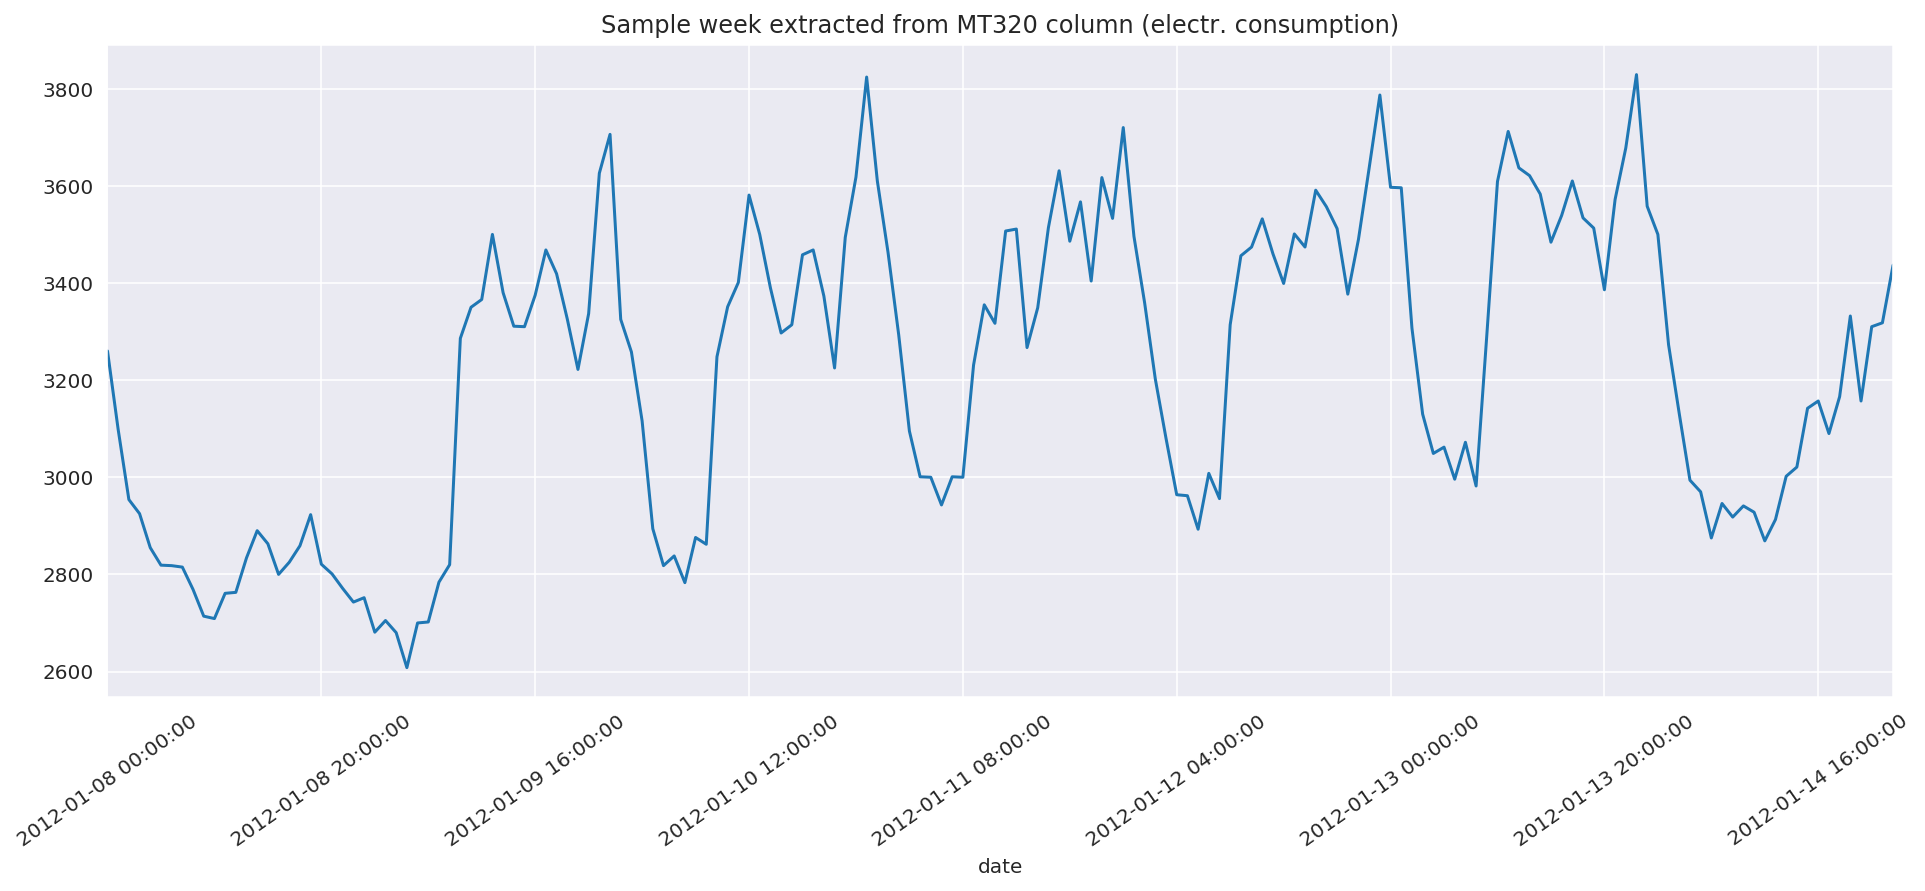

In [ ]:
electr_df.set_index("date")["320"][168:336].plot(title="Sample week extracted from MT320 column (electr. consumption)");
plt.xticks(rotation=35);

### 1-day Electricity Consumption Forecast Scenario

#### Informer Model declaration (1-day horizon)

Model architecture following authors recommendation for this dataset:




>  "Informer  contains  a  3-layer  stack  and  a  1-layer  stack  (1/4  input)  in  the  encoder,  and  a  2-layer  decoder.  Our  proposed  methods  are  optimized  with  Adam optimizer,  and  its  learning  rate  starts  from 1e−4,  decaying  two  times  smaller  every  epoch.  The  total  number  of epochs  is  8  with  proper  early  stopping.  We  set  the  comparison methods as recommended, and the batch size is 32."





<figure>
<center>
<img src='https://d3i71xaburhd42.cloudfront.net/5b9d8bcc46b766b47389c912a8e026f81b91b0d8/11-Table7-1.png' width="320" height="200"/>
<figcaption>Informer parameters for the experiments. Table 7 (Haoyi et al, 2021)</figcaption></center>
</figure>

In [134]:
args = dotdict()
args.data='custom'
args.root_path = "data/aggr_data/"
args.data_path = "electr_univ_proc_data.csv"
#Note: data is automatically scaled

timeenc = 0 if args.embed!='timeF' else 1

args.model = 'informer'

args.target = '320'
args.freq = 'h' # hourly data (frequency)
args.features = 'MS' # MS: Multiv input (date, target_prev) -> Single output (target_future)
args.checkpoints = './informer_checkpoints' # location of model checkpoints


args.seq_len = 24*7 # input sequence length of Informer encoder
args.label_len = 48 # start token length of Informer decoder
args.pred_len = 24 # prediction sequence length
# Informer decoder input: concat[start token series(label_len), zero padding series(pred_len)]

args.enc_in = 2 # encoder input size (2: date and target)
args.dec_in = 2 # decoder input size
args.c_out = 1 # output size
args.factor = 5 # probsparse attn factor
args.d_model = 512 # dimension of model
args.n_heads = 4 # num of heads
args.e_layers = 4 # num of encoder layers
args.d_layers = 2 # num of decoder layers
args.d_ff = 2048 # dimension of fcn in model
args.dropout = 0.1 # dropout
args.attn = 'prob' # attention used in encoder, options:[prob, full]
args.embed = 'timeF' # time features encoding, options:[timeF, fixed, learned]
args.activation = 'gelu' # activation
args.distil = True # whether to use distilling in encoder
args.output_attention = False # whether to output attention in ecoder

args.batch_size = 32 
args.learning_rate = 0.0001
args.loss = 'mse'
args.lradj = 'type1'
args.use_amp = False # whether to use automatic mixed precision training

args.num_workers = 0
args.itr = 1
args.train_epochs = 8
args.patience = 2
args.des = 'exp'

args.use_gpu = True if torch.cuda.is_available() else False
args.gpu = 0
args.use_multi_gpu = False

#### Model Training and Evaluation

Setups automatically a train/val/test of 15/3/4 months.

In [135]:
setting = '{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_at{}_fc{}_eb{}_dt{}_{}_{}'\
          .format(args.model, args.data, args.features, args.seq_len, args.label_len, args.pred_len, 
                  args.d_model, args.n_heads, args.e_layers, args.d_layers, args.d_ff, 
                  args.attn, args.factor, args.embed, args.distil, args.des, "electr1day")

exp = Exp_Informer(args)

Use GPU: cuda:0


In [ ]:
print('>>>>>>>Initiating model training : {}>>>>>>>>>>>>>>>>>>>'.format(setting))
exp.train(setting)

print('>>>>>>>Initiating model testing : {}<<<<<<<<<<<<<<<<<'.format(setting))
exp.test(setting)

torch.cuda.empty_cache()

Use GPU: cuda:0
>>>>>>>Initiating model training : informer_custom_ftMS_sl168_ll48_pl24_dm512_nh4_el4_dl2_df2048_atprob_fc5_ebtimeF_dtTrue_exp_1>>>>>>>>>>>>>>>>>>>
train 18221
val 2609
test 5237
	iters: 100, epoch: 1 | loss: 0.4821727
	speed: 0.4217s/iter; left time: 1877.9276s
	iters: 200, epoch: 1 | loss: 0.2712387
	speed: 0.4241s/iter; left time: 1846.2917s
	iters: 300, epoch: 1 | loss: 0.2471829
	speed: 0.4247s/iter; left time: 1806.1781s
	iters: 400, epoch: 1 | loss: 0.1481220
	speed: 0.4248s/iter; left time: 1764.2669s
	iters: 500, epoch: 1 | loss: 0.1696582
	speed: 0.4249s/iter; left time: 1722.2981s
Epoch: 1 cost time: 241.56737327575684
Epoch: 1, Steps: 569 | Train Loss: 0.3228063 Vali Loss: 0.2217779 Test Loss: 0.3056371
Validation loss decreased (inf --> 0.221778).  Saving model ...
Updating learning rate to 0.0001
	iters: 100, epoch: 2 | loss: 0.1535055
	speed: 1.1779s/iter; left time: 4574.8210s
	iters: 200, epoch: 2 | loss: 0.1856467
	speed: 0.4249s/iter; left time: 1607.

In [ ]:
# storing trained model parameters
torch.save(exp.model.state_dict(), "../trained_models/informer_model_electr_1day.pth" )

We can now re-load the dataset and trained model (with same parameters and learned weights):

In [136]:
timeenc = 0 if args.embed!='timeF' else 1

shuffle_flag = False; drop_last = True; batch_size = 1

data_set = Dataset_Custom(
    root_path=args.root_path,
    data_path=args.data_path,
    flag='test',
    size=[args.seq_len, args.label_len, args.pred_len],
    features=args.features,
    timeenc=timeenc,
    target=args.target,
    freq=args.freq
)

data_loader = DataLoader(
    data_set,
    batch_size=batch_size,
    shuffle=shuffle_flag,
    num_workers=args.num_workers,
    drop_last=drop_last)

Let's obtained unscaled predictions & true values for computing unscaled test MAE metric and plotting a sample week:

In [137]:
preds = np.load('./results/'+setting+'/pred.npy')
trues = np.load('./results/'+setting+'/true.npy')
# have shape [samples, pred_len, dimensions]

unscaled_trues = data_set.inverse_transform(trues)
unscaled_preds = data_set.inverse_transform(preds)

test_mae = []
for week_window in range(len(unscaled_trues)):
    week_trues = unscaled_trues[week_window,:,1]
    week_preds = unscaled_preds[week_window,:,1]
    week_MAE = mean_absolute_error(week_trues, week_preds)
    test_mae.append(week_MAE)

print("Average test MAE:", sum(test_mae)/len(test_mae))

Average test MAE: 215.54963089526498


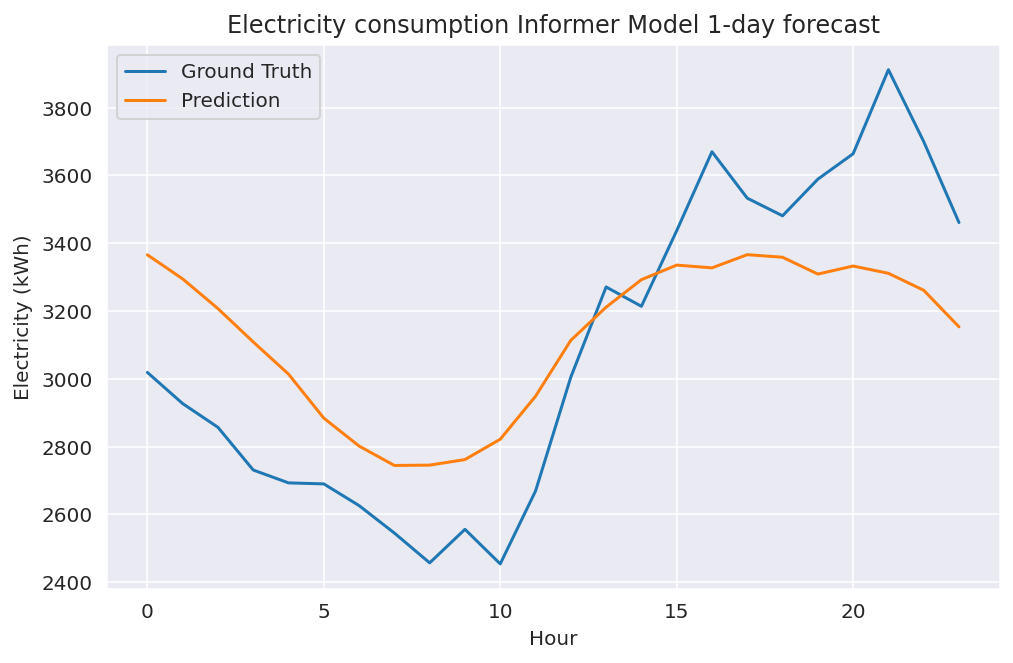

In [147]:
# plotting a test prediction sample
plt.figure(figsize=(8,5))
plt.plot(unscaled_trues[0,:,1], label='Ground Truth')
plt.plot(unscaled_preds[0,:,1], label='Prediction')
plt.title("Electricity consumption Informer Model 1-day forecast");
plt.xlabel("Hour"), plt.ylabel("Electricity (kWh)");
plt.legend()
plt.show()

#### Model and Forecasts Interpretation

and specify to output the attention layer weights to visualize them:

In [9]:
args.output_attention = True

exp = Exp_Informer(args)

model = exp.model

setting = "informer_custom_ftMS_sl168_ll48_pl24_dm512_nh4_el4_dl2_df2048_atprob_fc5_ebtimeF_dtTrue_exp_electr1day"
path = os.path.join(args.checkpoints,setting,'checkpoint.pth')
model.load_state_dict(torch.load(path))

Use GPU: cuda:0


<All keys matched successfully>

We can also visualize the attention heads layers activation so that we can gain some extra insights on their process:

In [10]:
idx = 0
for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(data_loader):
    if i!=idx:
        continue
    batch_x = batch_x.float().to(exp.device)
    batch_y = batch_y.float()

    batch_x_mark = batch_x_mark.float().to(exp.device)
    batch_y_mark = batch_y_mark.float().to(exp.device)
    
    dec_inp = torch.zeros_like(batch_y[:,-args.pred_len:,:]).float()
    dec_inp = torch.cat([batch_y[:,:args.label_len,:], dec_inp], dim=1).float().to(exp.device)
    
    outputs,attn = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)

In [11]:
attn[0].shape, attn[1].shape #, attn[2].shape

(torch.Size([1, 4, 168, 168]), torch.Size([1, 4, 85, 85]))

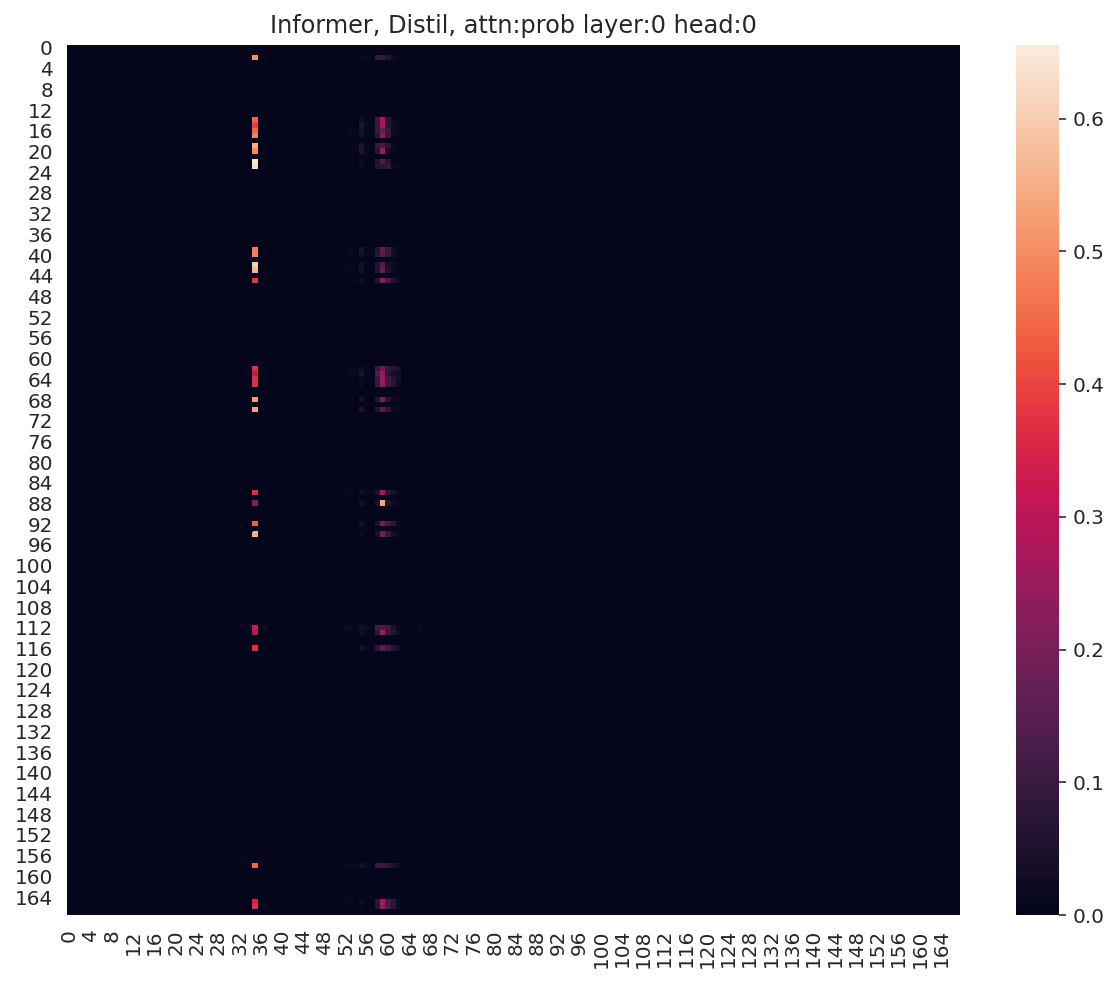

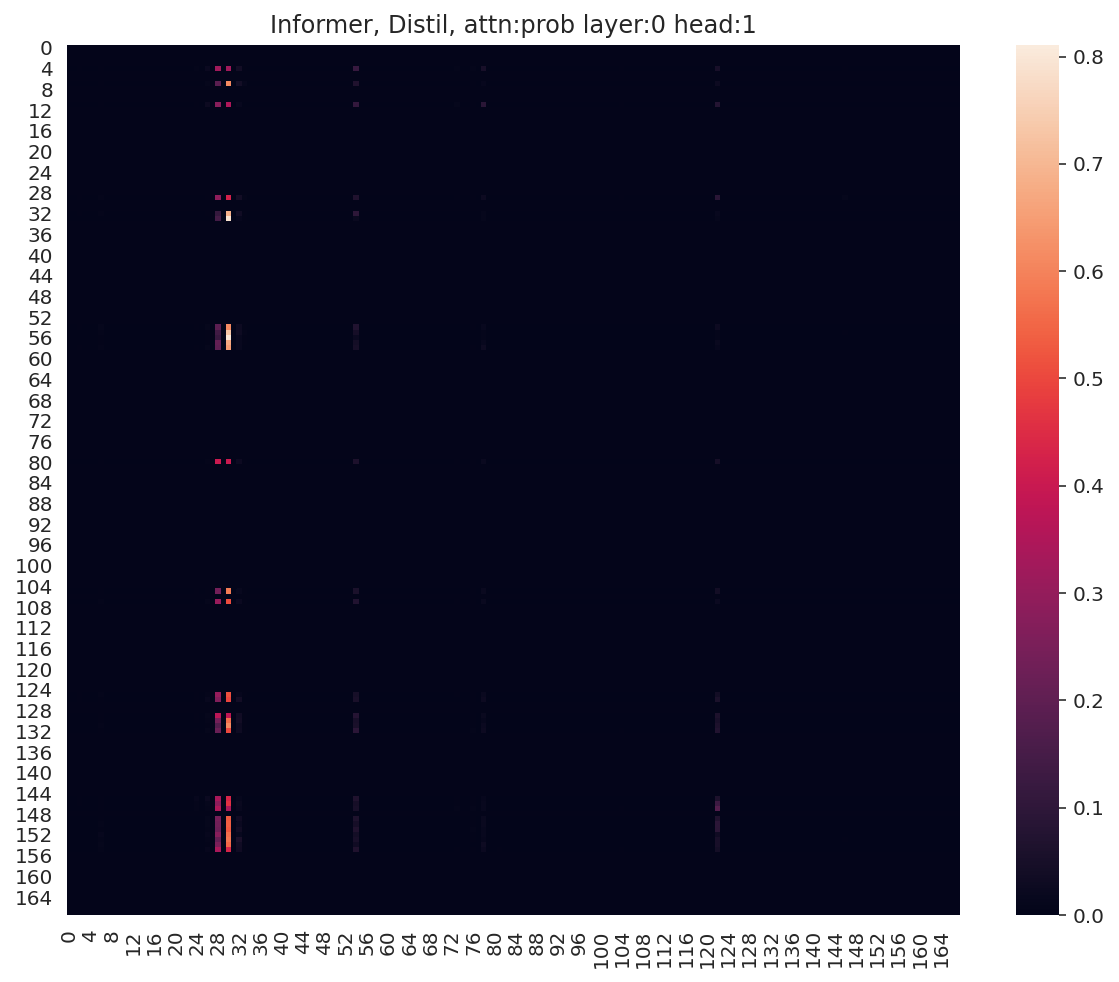

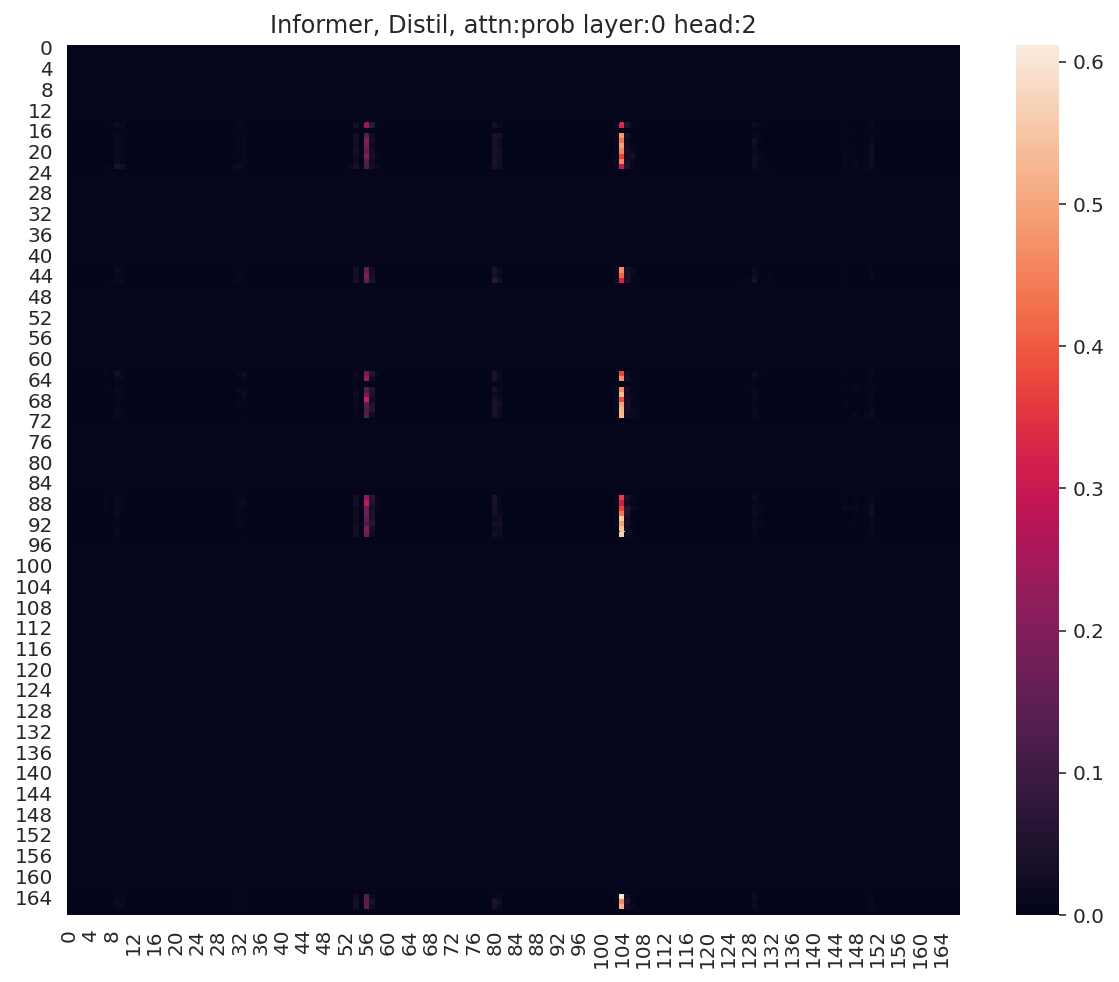

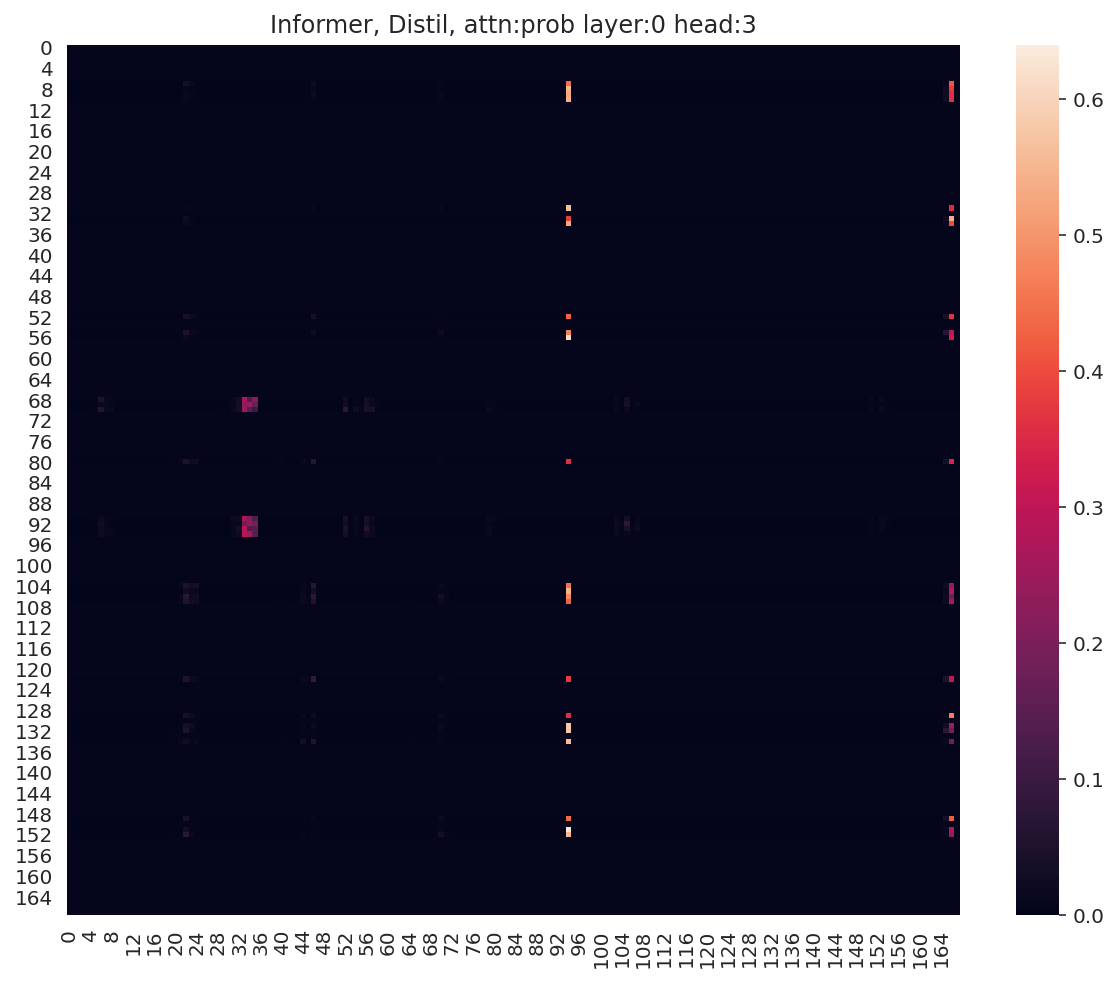

In [12]:
layer = 0
distil = 'Distil' if args.distil else 'NoDistil'
for h in range(0, args.n_heads):
    plt.figure(figsize=[10,8])
    plt.title('Informer, {}, attn:{} layer:{} head:{}'.format(distil, args.attn, layer, h))
    A = attn[layer][0,h].detach().cpu().numpy()
    ax = sns.heatmap(A, vmin=0, vmax=A.max()+0.01)
    plt.show()

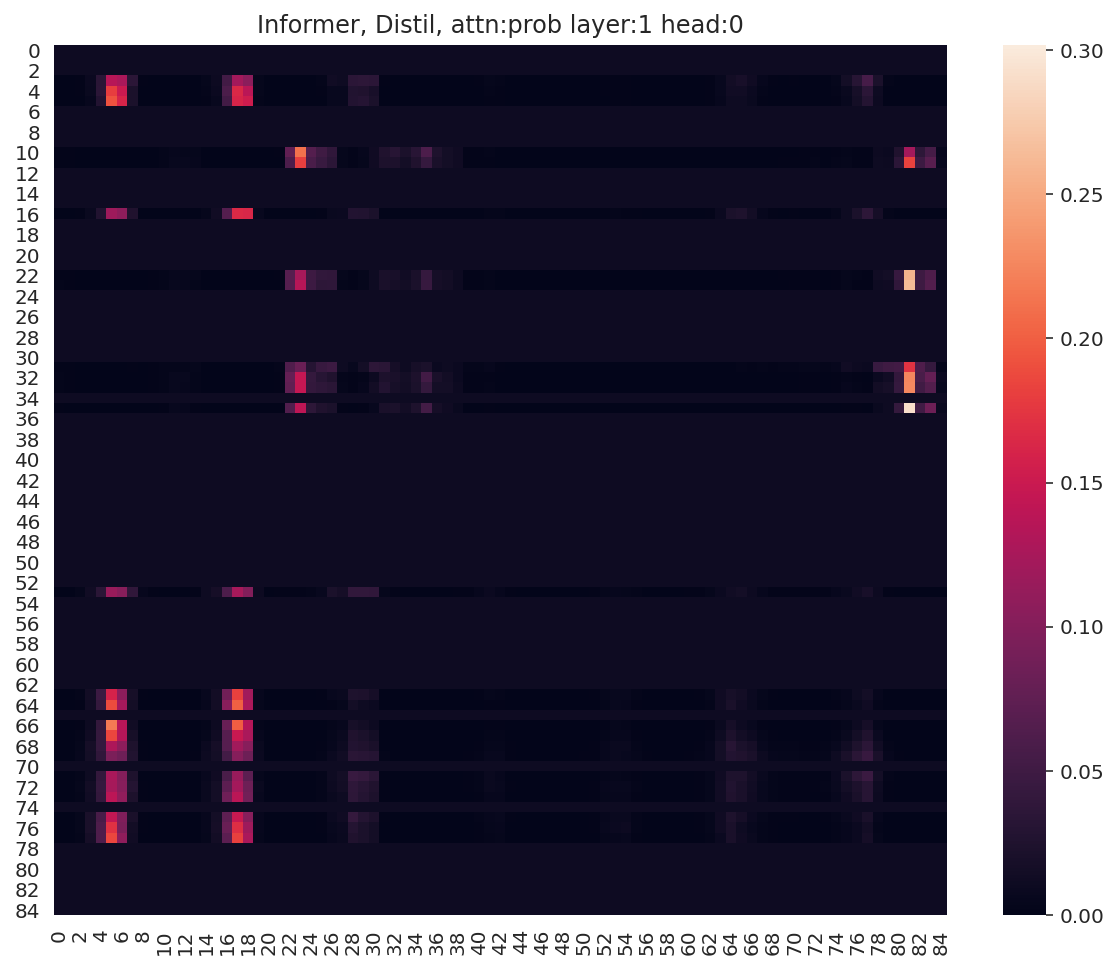

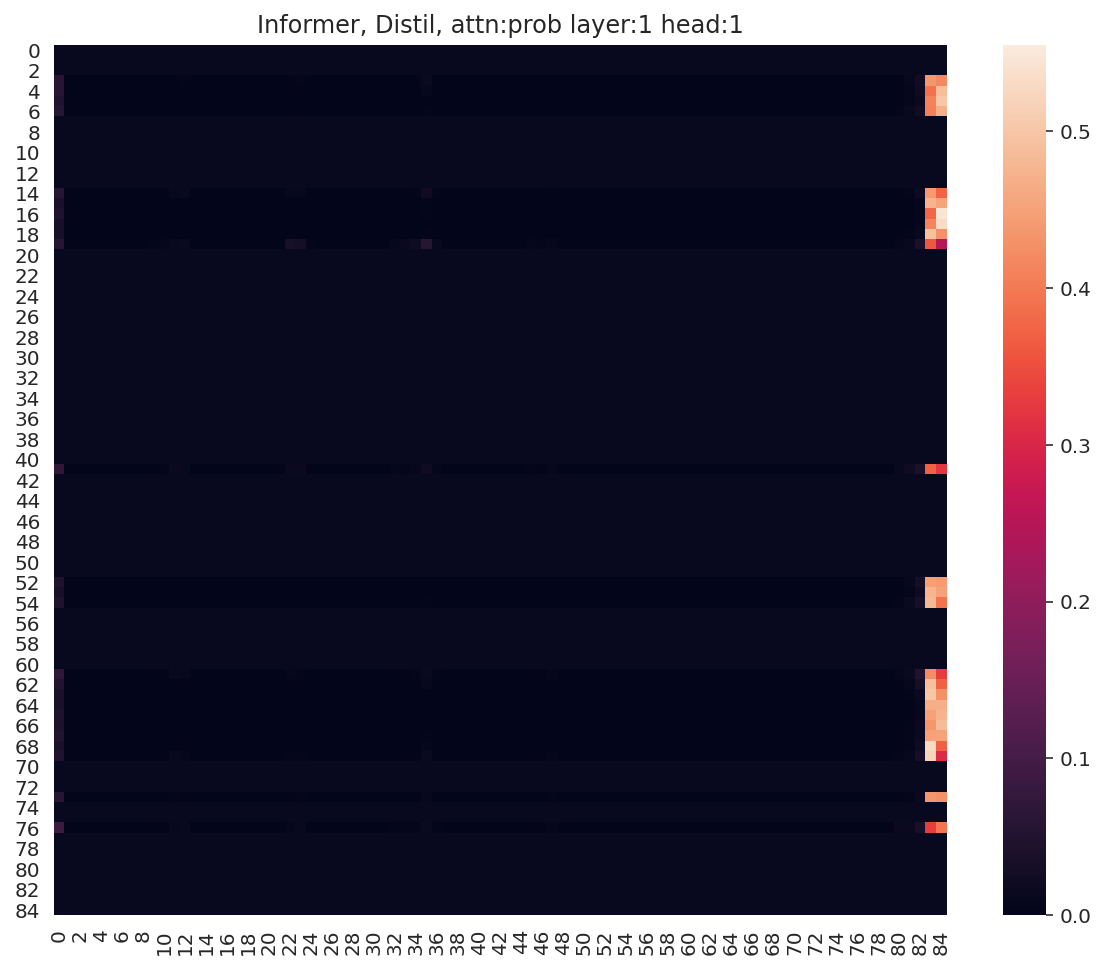

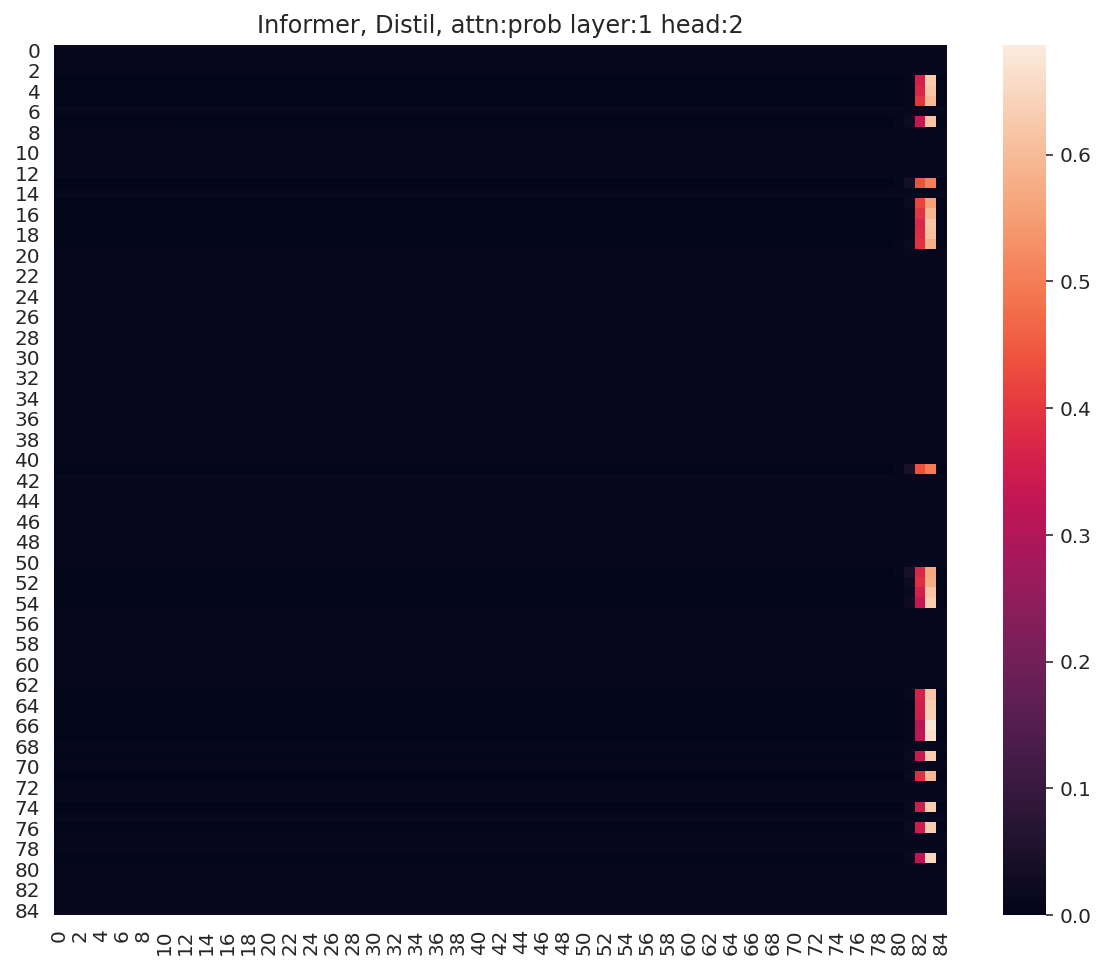

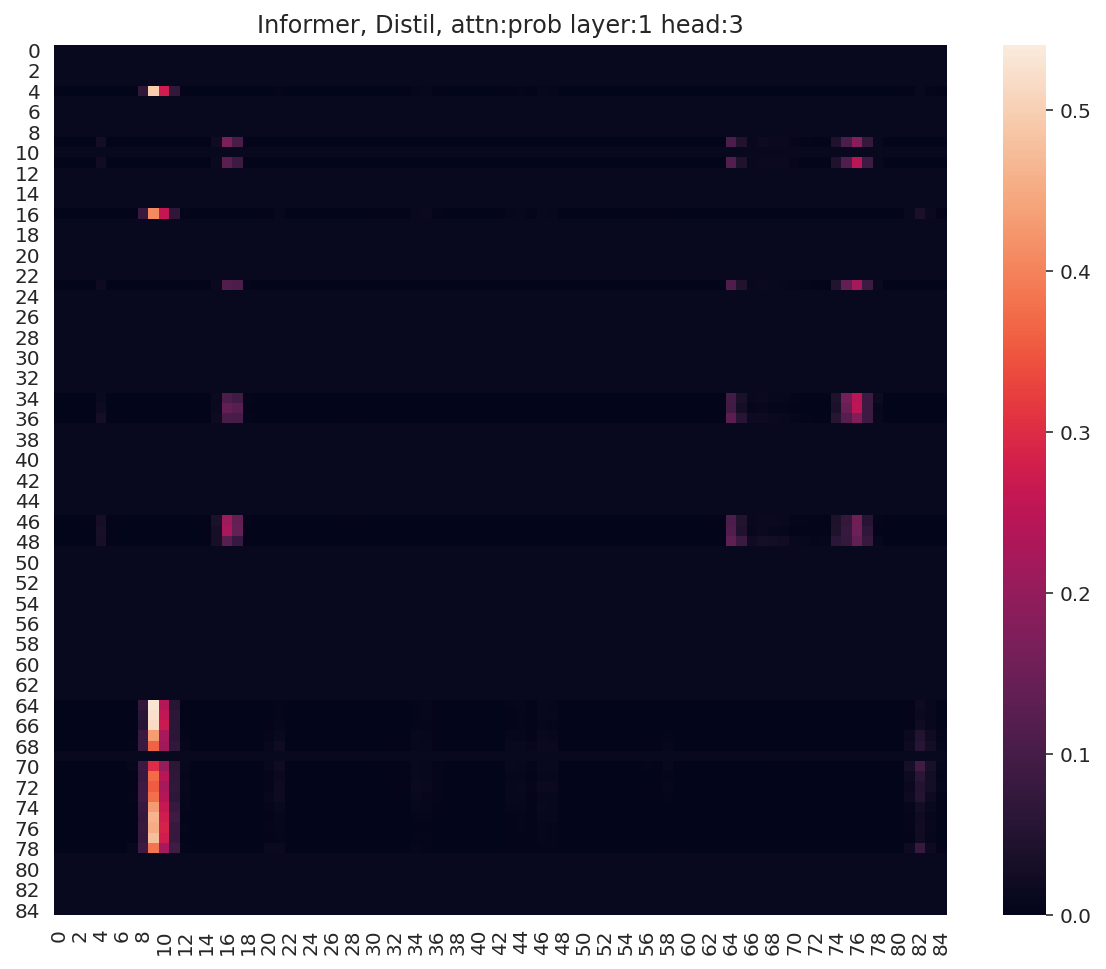

In [13]:
layer = 1
distil = 'Distil' if args.distil else 'NoDistil'
for h in range(0,args.n_heads):
    plt.figure(figsize=[10,8])
    plt.title('Informer, {}, attn:{} layer:{} head:{}'.format(distil, args.attn, layer, h))
    A = attn[layer][0,h].detach().cpu().numpy()
    ax = sns.heatmap(A, vmin=0, vmax=A.max()+0.01)
    plt.show()

### 1-week Electricity Consumption Forecast Scenario

Now we will apply the same though process as before (model declaration -> model training and evaluation -> model and forecasts interpretation) but considering a forecast horizon of 1 week. Note that the model authors did not consider this scenario, but I consider it also for my work.

#### Informer Model declaration (1-week horizon)

Same reasoning as before, but now specifying a longer forecast horizon (of 7 days instead of 1).

In [148]:
args = dotdict()
args.data='custom'
args.root_path = "data/aggr_data/"
args.data_path = "electr_univ_proc_data.csv"
#Note: data is automatically scaled

timeenc = 0 if args.embed!='timeF' else 1

args.model = 'informer'

args.target = '320'
args.freq = 'h' # hourly data (frequency)
args.features = 'MS' # MS: Multiv input (date, target_prev) -> Single output (target_future)
args.checkpoints = './informer_checkpoints' # location of model checkpoints


args.seq_len = 24*7 # input sequence length of Informer encoder
args.label_len = 48 # start token length of Informer decoder
args.pred_len = 7*24 # prediction sequence length ===> NOW IS 1 WEEK (7 DAYS)


args.enc_in = 2 # encoder input size (2: date and target)
args.dec_in = 2 # decoder input size
args.c_out = 1 # output size
args.factor = 5 # probsparse attn factor
args.d_model = 512 # dimension of model
args.n_heads = 4 # num of heads
args.e_layers = 4 # num of encoder layers
args.d_layers = 2 # num of decoder layers
args.d_ff = 2048 # dimension of fcn in model
args.dropout = 0.1 # dropout
args.attn = 'prob' # attention used in encoder, options:[prob, full]
args.embed = 'timeF' # time features encoding, options:[timeF, fixed, learned]
args.activation = 'gelu' # activation
args.distil = True # whether to use distilling in encoder
args.output_attention = False # whether to output attention in ecoder

args.batch_size = 32 
args.learning_rate = 0.0001
args.loss = 'mse'
args.lradj = 'type1'
args.use_amp = False # whether to use automatic mixed precision training

args.num_workers = 0
args.itr = 1
args.train_epochs = 8
args.patience = 2
args.des = 'exp'

args.use_gpu = True if torch.cuda.is_available() else False
args.gpu = 0
args.use_multi_gpu = False

#### Model Training and Evaluation

In [149]:
setting = '{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_at{}_fc{}_eb{}_dt{}_{}_{}'\
          .format(args.model, args.data, args.features, args.seq_len, args.label_len, args.pred_len, 
                  args.d_model, args.n_heads, args.e_layers, args.d_layers, args.d_ff, 
                  args.attn, args.factor, args.embed, args.distil, args.des, "electr1week")

# set experiment model
exp_week = Exp_Informer(args)

Use GPU: cuda:0


In [16]:
print('>>>>>>>start training : {}>>>>>>>>>>>>>>>>>>>>>>>>>>'.format(setting))
exp_week.train(setting)

print('>>>>>>>testing : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
exp_week.test(setting)

torch.cuda.empty_cache()

>>>>>>>start training : informer_custom_ftMS_sl168_ll48_pl168_dm512_nh4_el4_dl2_df2048_atprob_fc5_ebtimeF_dtTrue_exp_1>>>>>>>>>>>>>>>>>>>>>>>>>>
train 18077
val 2465
test 5093
	iters: 100, epoch: 1 | loss: 0.6317997
	speed: 0.2700s/iter; left time: 1191.3614s
	iters: 200, epoch: 1 | loss: 0.6331757
	speed: 0.2804s/iter; left time: 1209.4050s
	iters: 300, epoch: 1 | loss: 0.3309534
	speed: 0.2888s/iter; left time: 1216.6942s
	iters: 400, epoch: 1 | loss: 0.2735803
	speed: 0.2854s/iter; left time: 1173.8844s
	iters: 500, epoch: 1 | loss: 0.2422358
	speed: 0.2843s/iter; left time: 1140.9658s
Epoch: 1 cost time: 159.40682673454285
Epoch: 1, Steps: 564 | Train Loss: 0.4275022 Vali Loss: 0.3097203 Test Loss: 0.5532656
Validation loss decreased (inf --> 0.309720).  Saving model ...
Updating learning rate to 0.0001
	iters: 100, epoch: 2 | loss: 0.2131717
	speed: 0.7356s/iter; left time: 2831.1683s
	iters: 200, epoch: 2 | loss: 0.2525151
	speed: 0.2846s/iter; left time: 1066.8987s
	iters: 300, 

In [19]:
# storing trained model parameters
torch.save(exp_week.model.state_dict(), "../trained_models/informer_model_electr_1week.pth" )

In [150]:
timeenc = 0 if args.embed!='timeF' else 1

shuffle_flag = False; drop_last = True; batch_size = 1

data_set = Dataset_Custom(
    root_path=args.root_path,
    data_path=args.data_path,
    flag='test',
    size=[args.seq_len, args.label_len, args.pred_len],
    features=args.features,
    timeenc=timeenc,
    target=args.target,
    freq=args.freq
)

data_loader = DataLoader(
    data_set,
    batch_size=batch_size,
    shuffle=shuffle_flag,
    num_workers=args.num_workers,
    drop_last=drop_last)

Let's obtained unscaled predictions & true values for computing unscaled test MAE metric and plotting a sample week:

In [151]:
preds = np.load('./results/'+setting+'/pred.npy')
trues = np.load('./results/'+setting+'/true.npy')
# have shape [samples, pred_len, dimensions]

unscaled_trues = data_set.inverse_transform(trues)
unscaled_preds = data_set.inverse_transform(preds)

test_mae = []
for week_window in range(len(unscaled_trues)):
    week_trues = unscaled_trues[week_window,:,1]
    week_preds = unscaled_preds[week_window,:,1]
    week_MAE = mean_absolute_error(week_trues, week_preds)
    test_mae.append(week_MAE)

print("Average test MAE:", sum(test_mae)/len(test_mae))

Average test MAE: 349.70489629696846


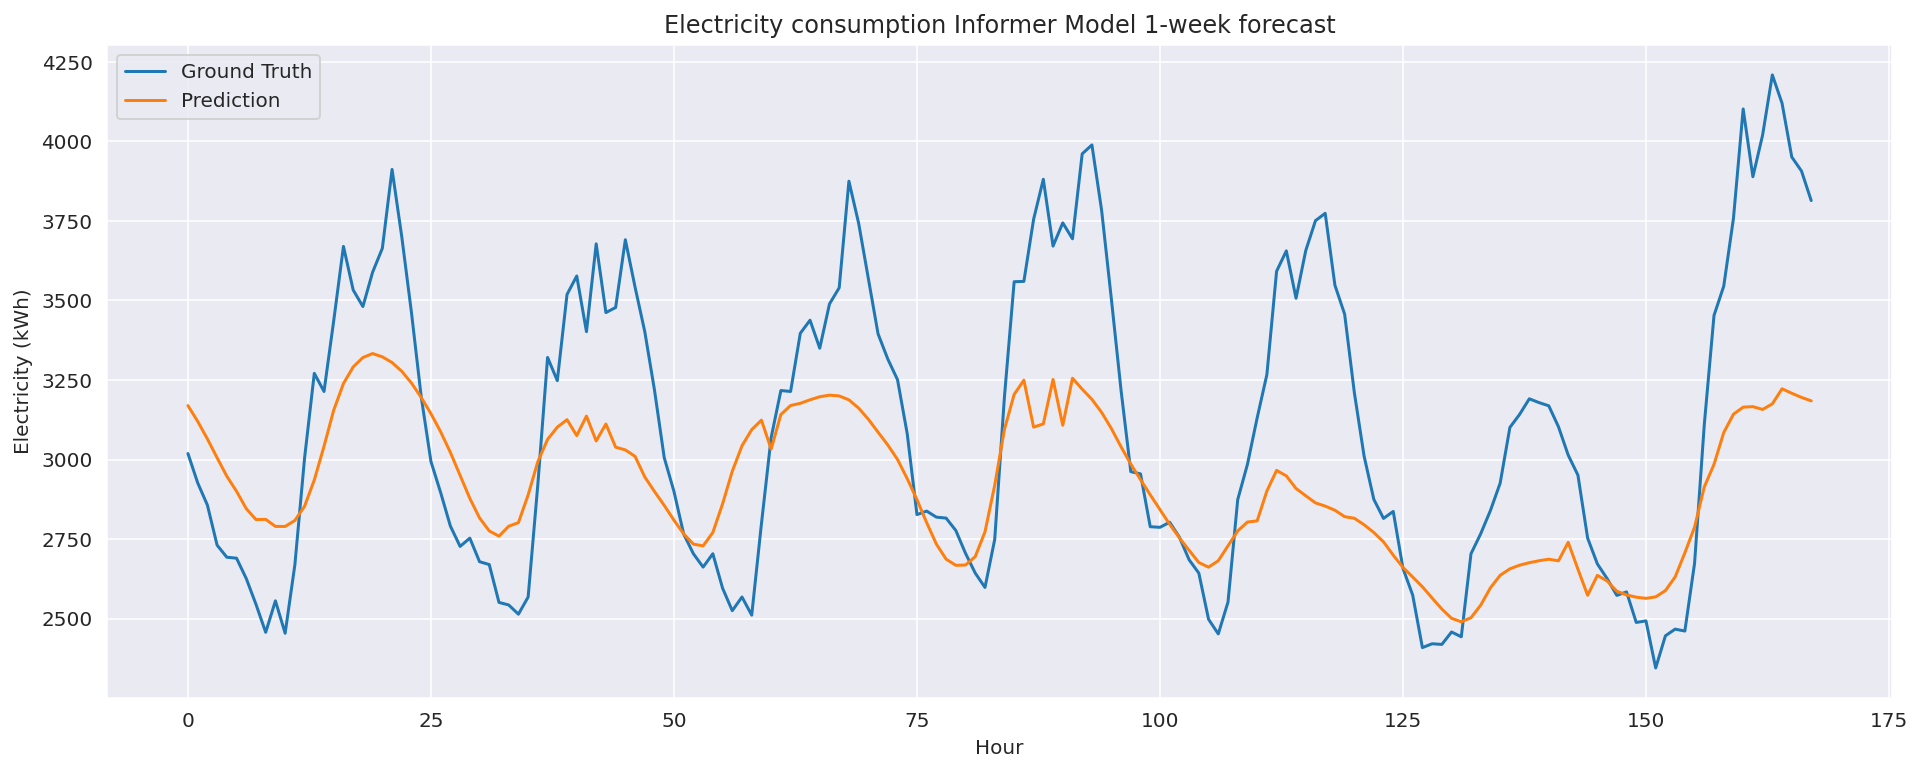

In [152]:
plt.figure()
plt.plot(unscaled_trues[0,:,1], label='Ground Truth')
plt.plot(unscaled_preds[0,:,1], label='Prediction')
plt.title("Electricity consumption Informer Model 1-week forecast");
plt.xlabel("Hour"), plt.ylabel("Electricity (kWh)");
plt.legend()
plt.show()

#### Model and Forecasts Interpretation

In [33]:
args.output_attention = True

exp_week = Exp_Informer(args)

model = exp_week.model

setting = "informer_custom_ftMS_sl168_ll48_pl168_dm512_nh4_el4_dl2_df2048_atprob_fc5_ebtimeF_dtTrue_exp_electr1week"
path = os.path.join(args.checkpoints,setting,'checkpoint.pth')
model.load_state_dict(torch.load(path))

Use GPU: cuda:0


<All keys matched successfully>

In [35]:
# attention visualization
idx = 0
for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(data_loader):
    if i!=idx:
        continue
    batch_x = batch_x.float().to(exp.device)
    batch_y = batch_y.float()

    batch_x_mark = batch_x_mark.float().to(exp.device)
    batch_y_mark = batch_y_mark.float().to(exp.device)
    
    dec_inp = torch.zeros_like(batch_y[:,-args.pred_len:,:]).float()
    dec_inp = torch.cat([batch_y[:,:args.label_len,:], dec_inp], dim=1).float().to(exp.device)
    
    outputs,attn = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)

In [37]:
attn[0].shape, attn[1].shape, attn[2].shape

(torch.Size([1, 4, 168, 168]),
 torch.Size([1, 4, 85, 85]),
 torch.Size([1, 4, 44, 44]))

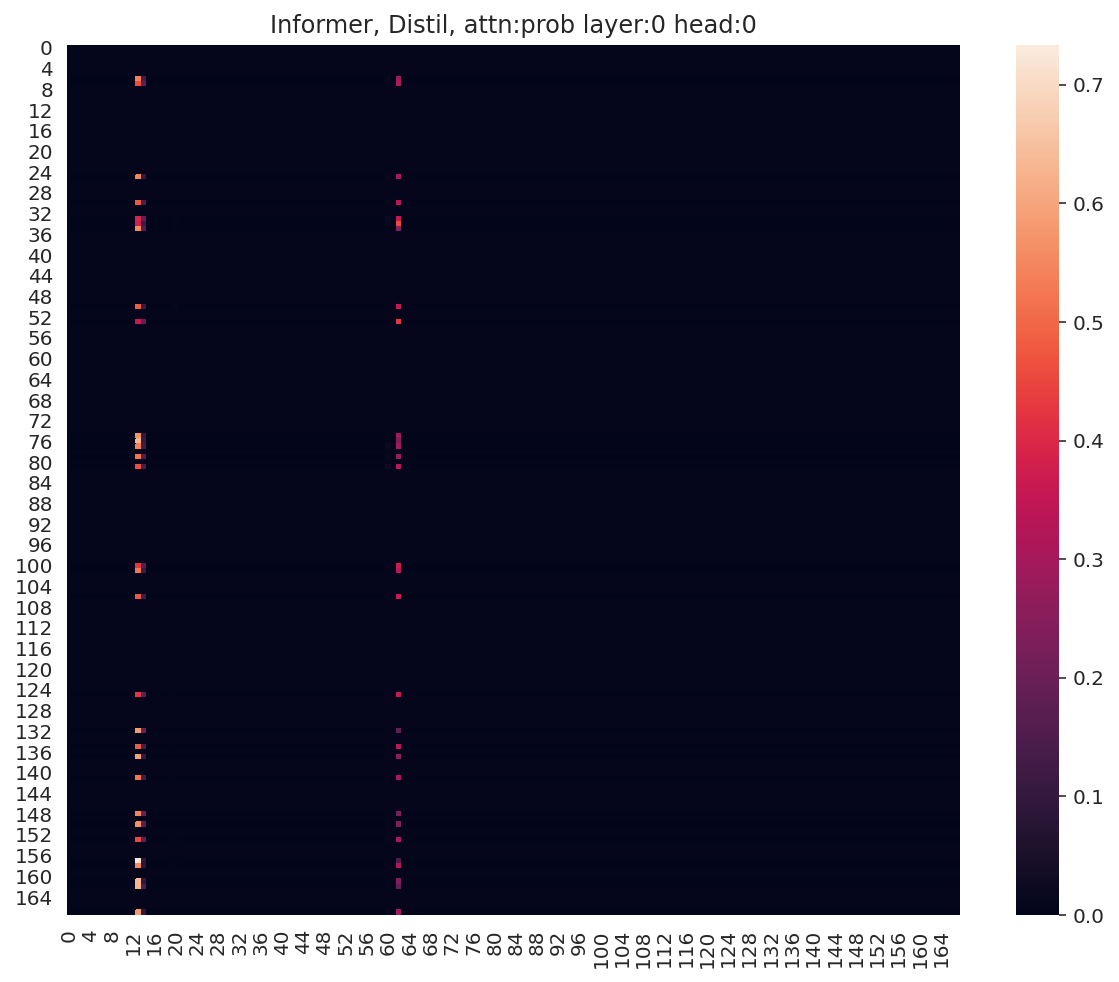

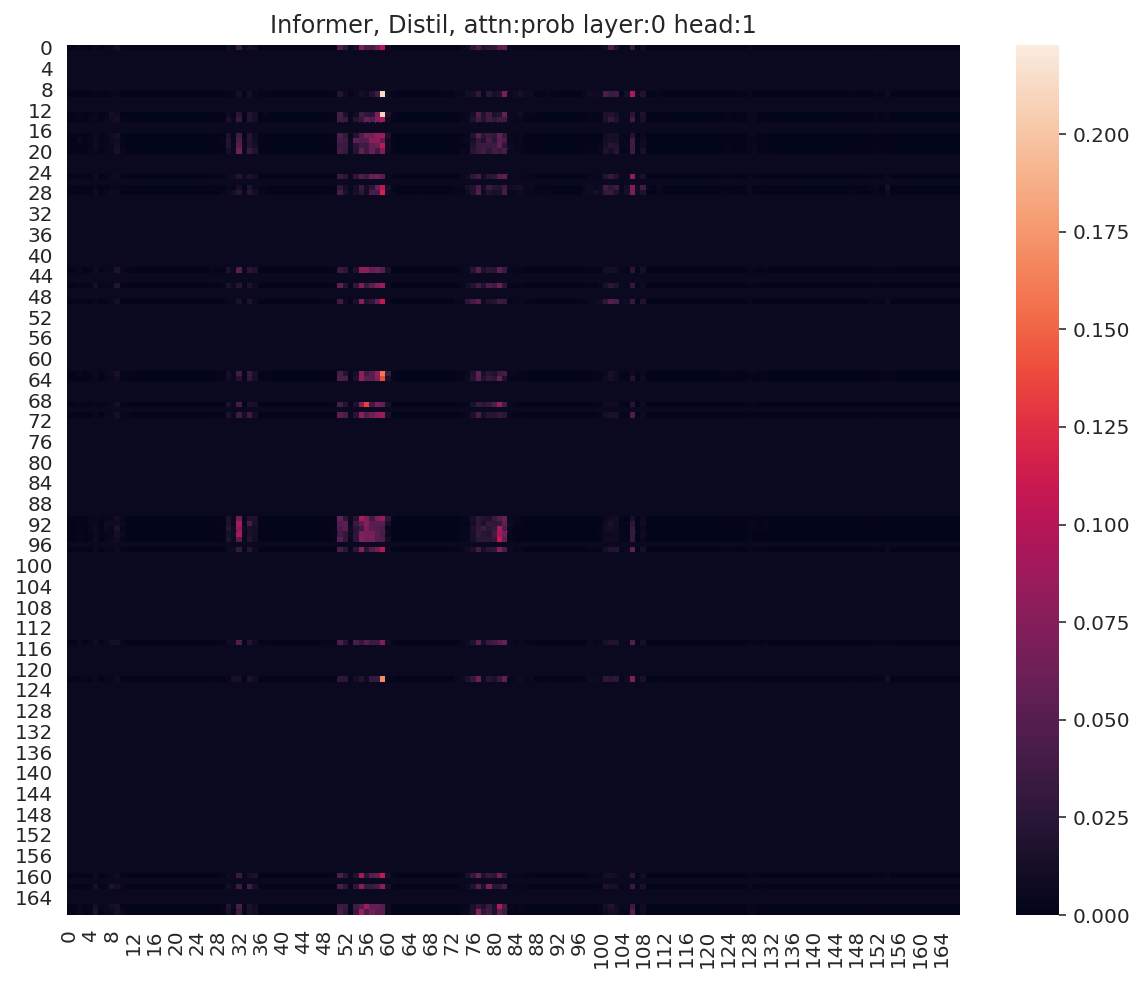

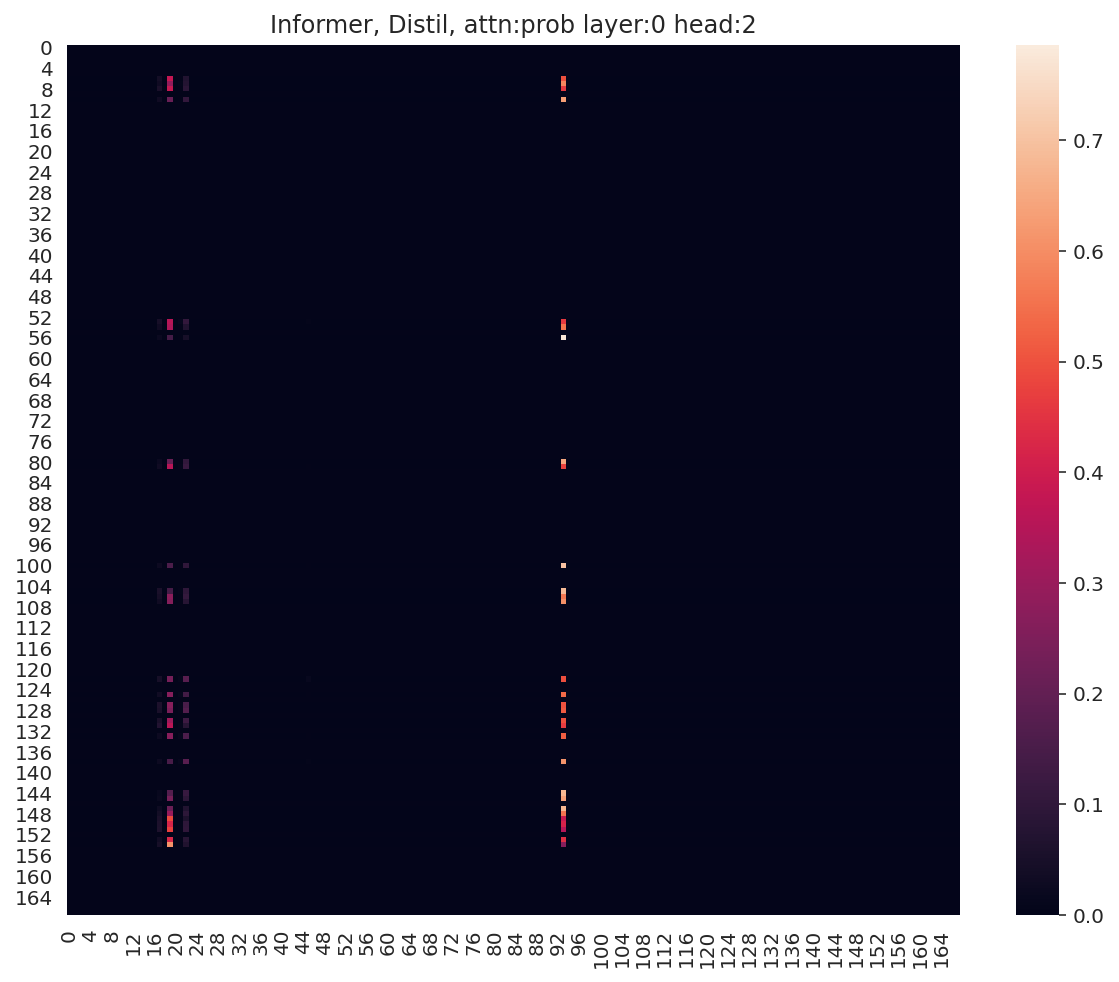

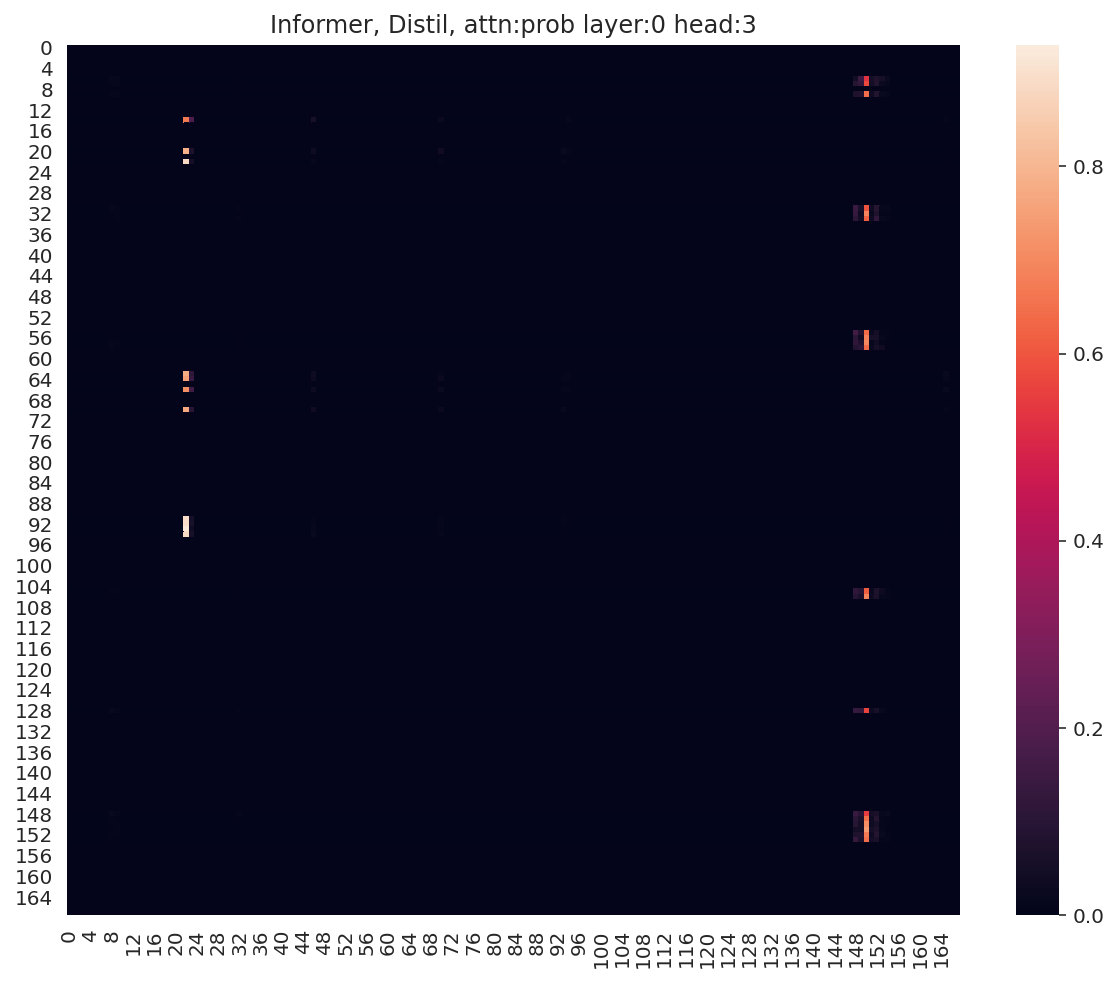

In [38]:
layer = 0
distil = 'Distil' if args.distil else 'NoDistil'
for h in range(0, args.n_heads):
    plt.figure(figsize=[10,8])
    plt.title('Informer, {}, attn:{} layer:{} head:{}'.format(distil, args.attn, layer, h))
    A = attn[layer][0,h].detach().cpu().numpy()
    ax = sns.heatmap(A, vmin=0, vmax=A.max()+0.01)
    plt.show()

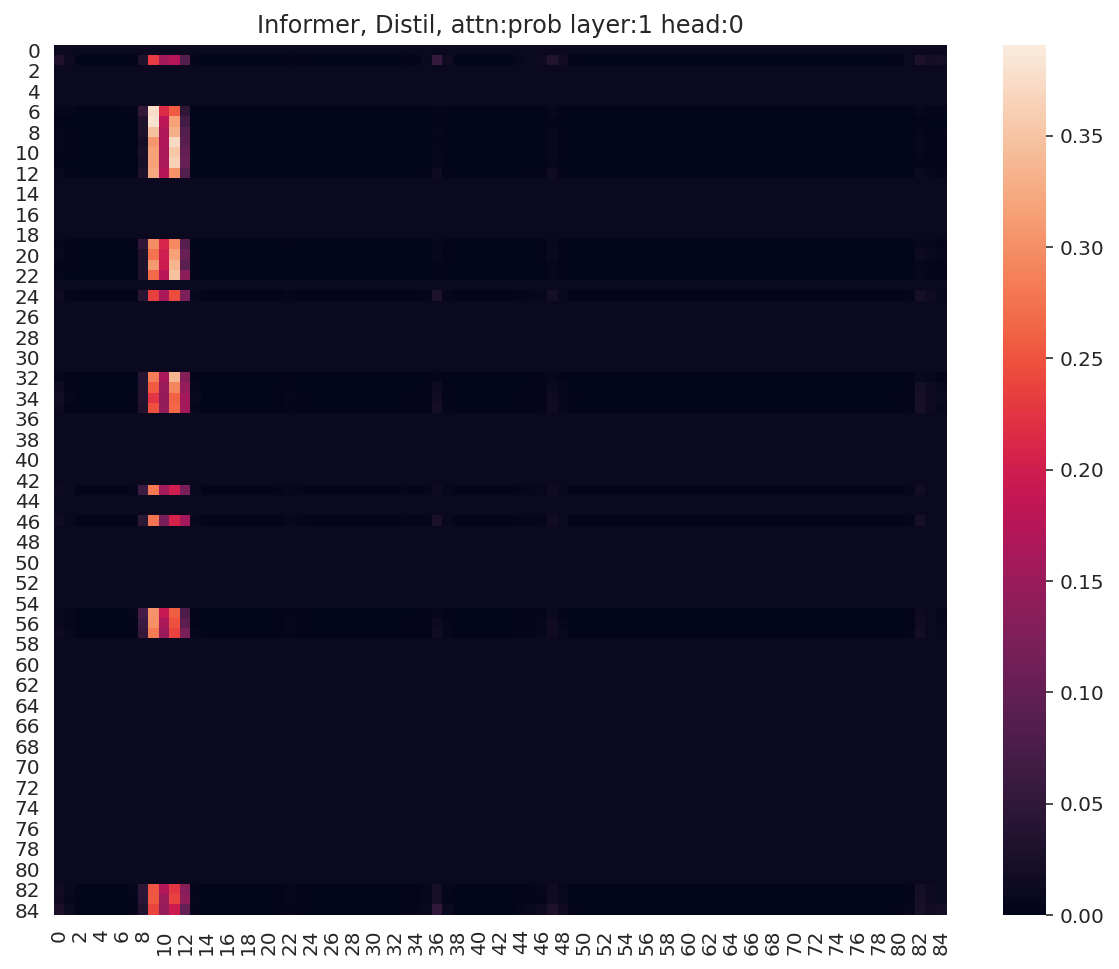

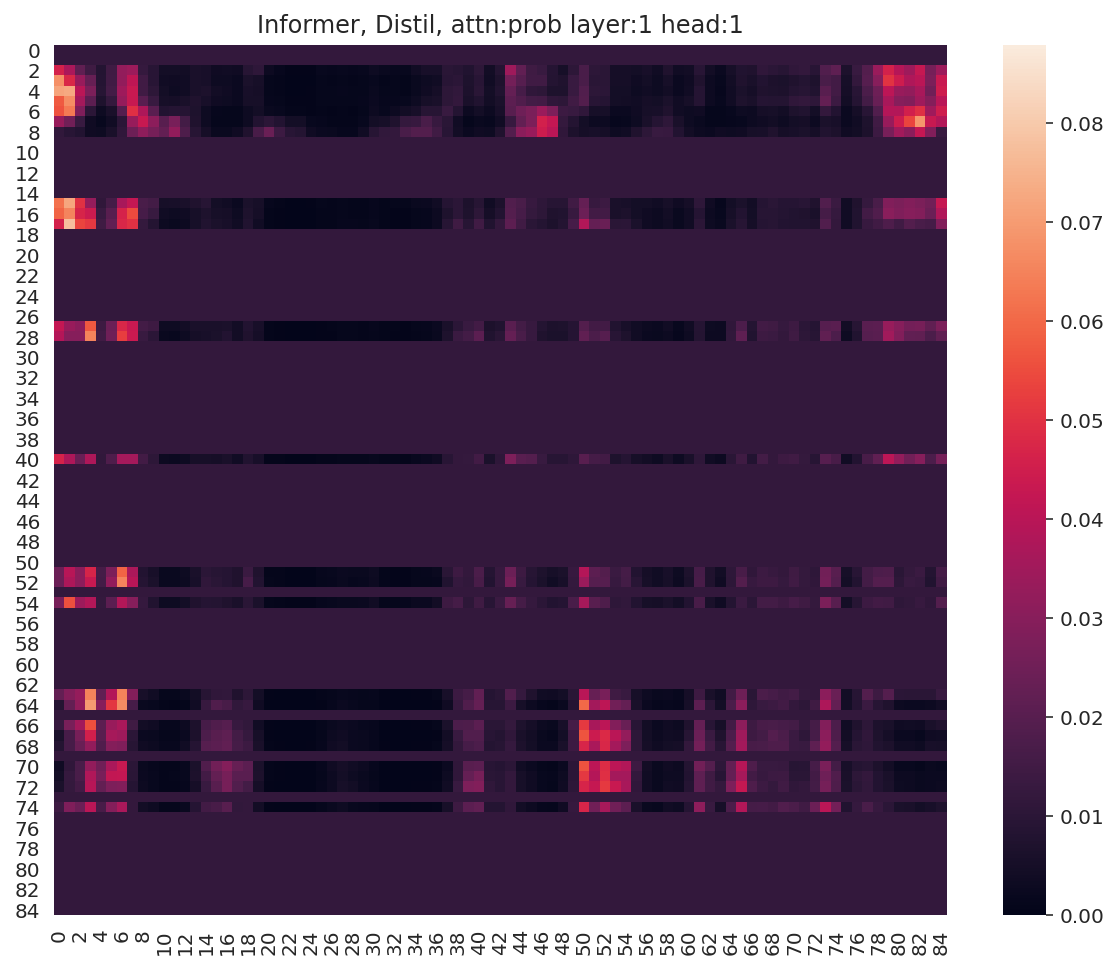

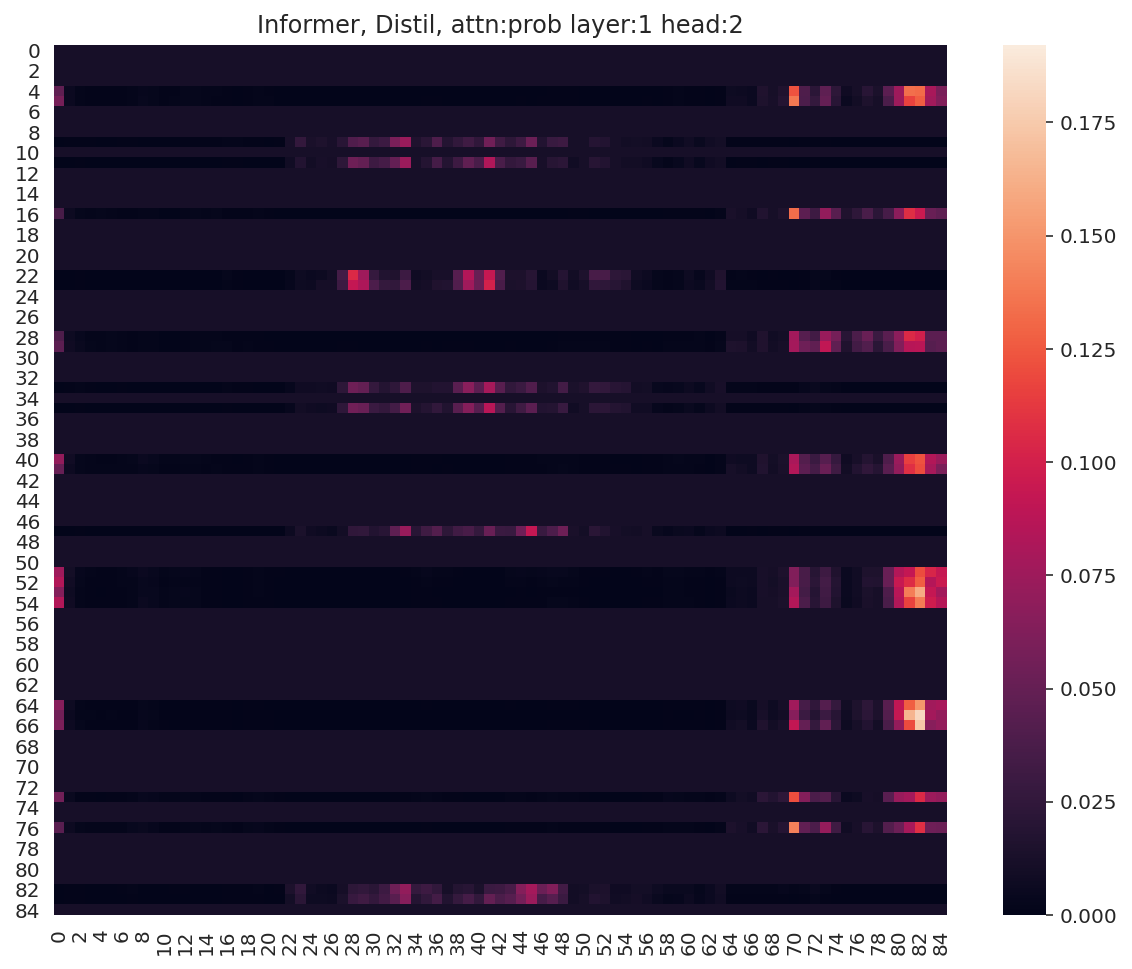

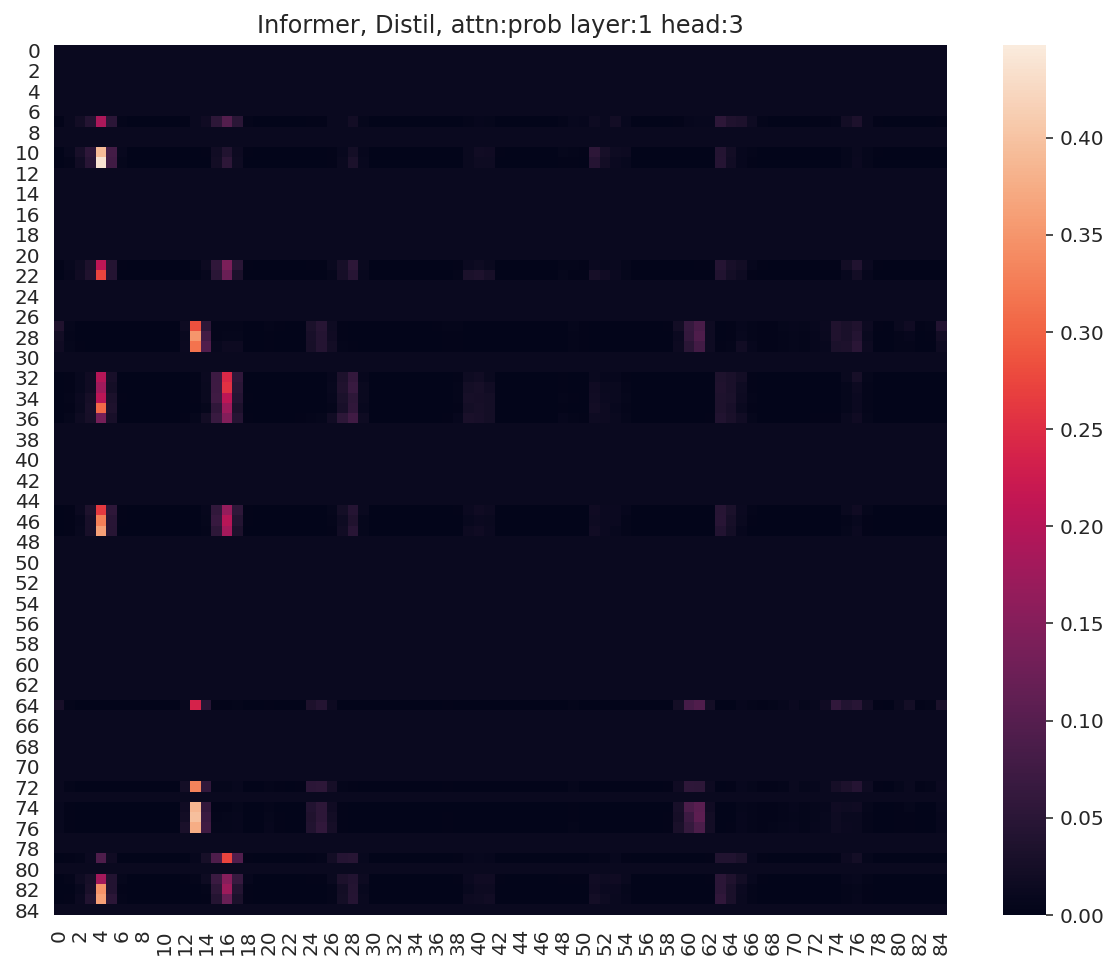

In [80]:
layer = 1
distil = 'Distil' if args.distil else 'NoDistil'
for h in range(0,args.n_heads):
    plt.figure(figsize=[10,8])
    plt.title('Informer, {}, attn:{} layer:{} head:{}'.format(distil, args.attn, layer, h))
    A = attn[layer][0,h].detach().cpu().numpy()
    ax = sns.heatmap(A, vmin=0, vmax=A.max()+0.01)
    plt.show()

## Traffic Dataset

### Loading aggregated traffic data

In [ ]:
traffic_df = pd.read_csv("data/aggr_data/traffic.txt", header=None)
traffic_df['date'] = pd.date_range(start='1/1/2015', periods=traffic_df.shape[0], freq="H")
traffic_df.to_csv("data/aggr_data/traffic_proc_data.csv") #to later use with library
# reorder columns
cols = traffic_df.columns.tolist() 
cols = cols[-1:] + cols[:-1]
traffic_df = traffic_df[cols]

In [5]:
# showing sample
traffic_df = pd.read_csv("data/aggr_data/traffic_proc_data.csv", index_col=0)
traffic_df.head()

date       0       1       2  ...     858     859     860     861
0  2008-01-01 00:00:00  0.0048  0.0146  0.0289  ...  0.0339  0.0051  0.0100  0.0121
1  2008-01-01 01:00:00  0.0072  0.0148  0.0350  ...  0.0348  0.0036  0.0087  0.0136
2  2008-01-01 02:00:00  0.0040  0.0101  0.0267  ...  0.0327  0.0030  0.0061  0.0107
3  2008-01-01 03:00:00  0.0039  0.0060  0.0218  ...  0.0292  0.0033  0.0040  0.0071
4  2008-01-01 04:00:00  0.0042  0.0055  0.0191  ...  0.0264  0.0049  0.0040  0.0039

[5 rows x 863 columns]

We are only interested in a single time series; that of road sensor #0.

In [71]:
traffic_df[["date", "0"]].to_csv("data/aggr_data/traffic_univ_proc_data.csv")

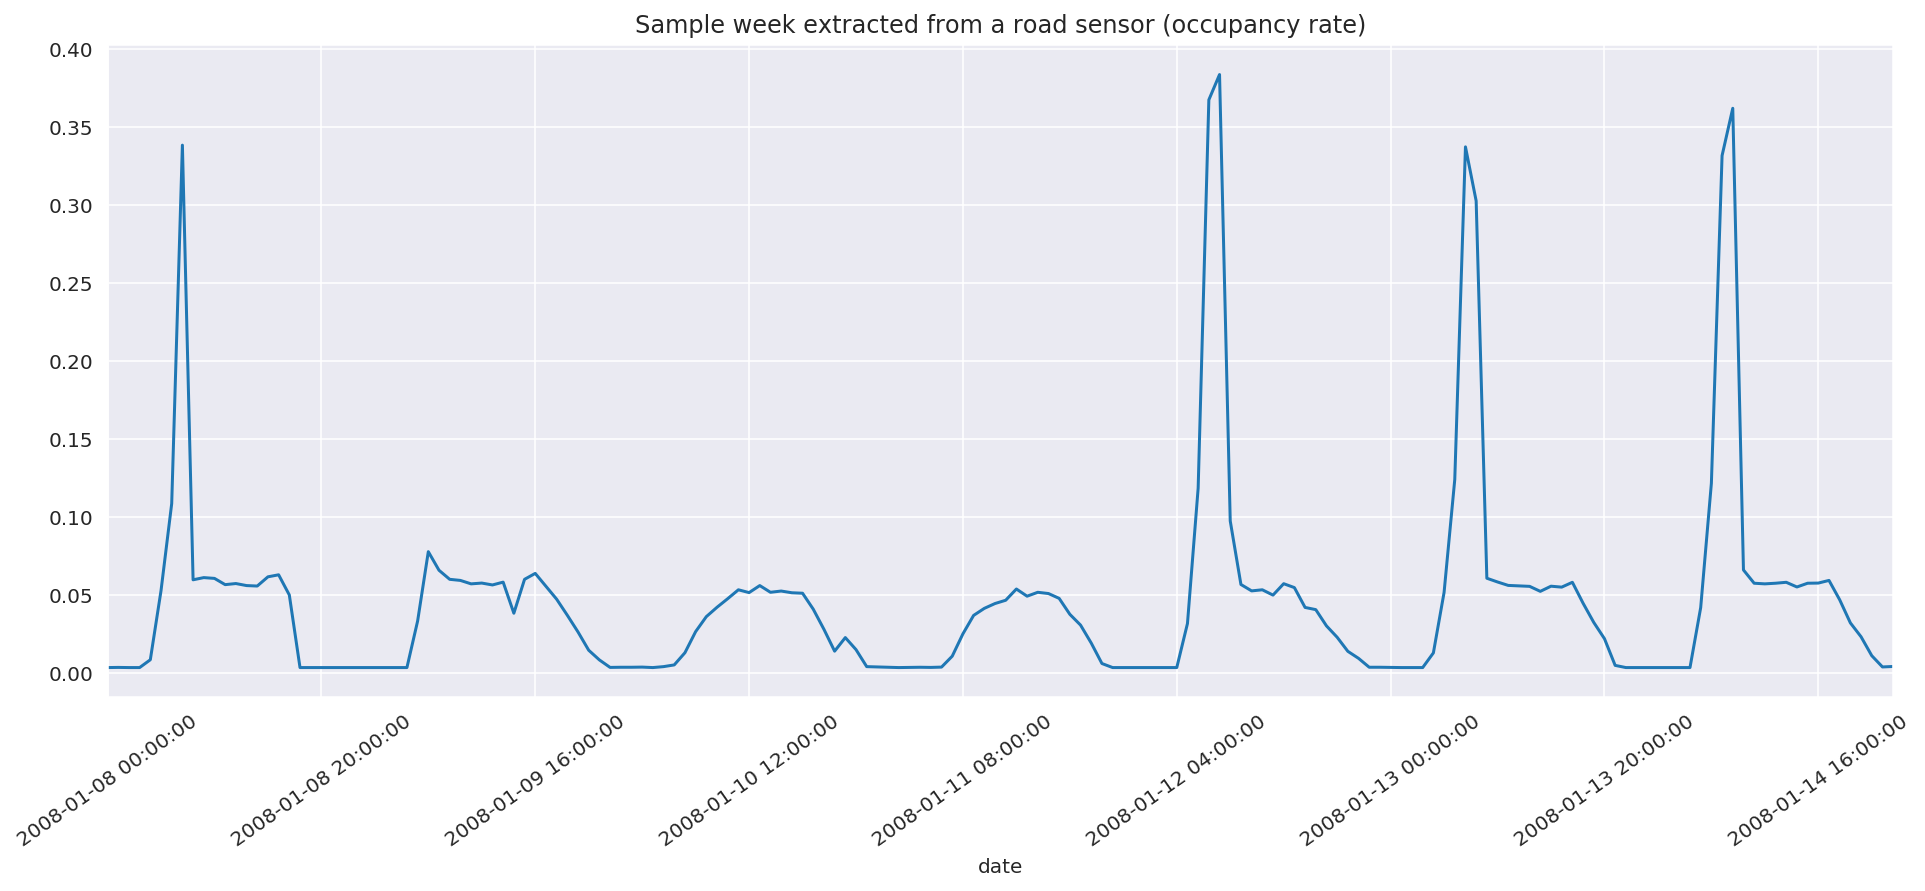

In [ ]:
traffic_df.set_index("date")["0"][168:336].plot(title="Sample week extracted from a road sensor (occupancy rate)");
plt.xticks(rotation=35);

### 1-day Traffic Occupation Rate Forecast Scenario

#### Informer Model Declaration (1-day horizon)

Model architecture parameters following authors recommendation for this dataset:

In [6]:
args = dotdict()
args.data='custom'
args.root_path = "data/aggr_data/"
args.data_path = "traffic_univ_proc_data.csv"
#Note: data is automatically scaled

timeenc = 0 if args.embed!='timeF' else 1

args.model = 'informer' 
args.target = '0'
args.freq = 'h' # hourly data (frequency)
args.features = 'MS' 
args.checkpoints = tfm_path+'Informer2020/informer_checkpoints'


args.seq_len = 24*7 # input sequence length of Informer encoder (pior week)
args.label_len = 48 # start token length of Informer decoder
args.pred_len = 24 # prediction sequence length
# Informer decoder input: concat[start token series(label_len), zero padding series(pred_len)]

args.enc_in = 2 # encoder input size (2: date and target)
args.dec_in = 2 # decoder input size
args.c_out = 1 # output size
args.factor = 5 # probsparse attn factor
args.d_model = 512 # dimension of model
args.n_heads = 4 # num of heads
args.e_layers = 4 # num of encoder layers
args.d_layers = 2 # num of decoder layers
args.d_ff = 2048 # dimension of fcn in model
args.dropout = 0.1 # dropout
args.attn = 'prob' # attention used in encoder, options:[prob, full]
args.embed = 'timeF' # time features encoding, options:[timeF, fixed, learned]
args.activation = 'gelu' # activation
args.distil = True # whether to use distilling in encoder
args.output_attention = False # whether to output attention in ecoder

args.batch_size = 32 
args.learning_rate = 0.0001
args.loss = 'mse'
args.lradj = 'type1'
args.use_amp = False # whether to use automatic mixed precision training

args.num_workers = 0
args.itr = 1
args.train_epochs = 8
args.patience = 2
args.des = 'exp'

args.use_gpu = True if torch.cuda.is_available() else False
args.gpu = 0
args.use_multi_gpu = False

#### Model Training and Evaluation

In [7]:
setting = '{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_at{}_fc{}_eb{}_dt{}_{}_{}'\
          .format(args.model, args.data, args.features, args.seq_len, args.label_len, args.pred_len, 
                  args.d_model, args.n_heads, args.e_layers, args.d_layers, args.d_ff, 
                  args.attn, args.factor, args.embed, args.distil, args.des, "traffic1day")

exp = Exp_Informer(args)

Use GPU: cuda:0


In [79]:
print('>>>>>>>start training : {}>>>>>>>>>>>>>>>>>>>>>>>>>>'.format(setting))
exp.train(setting)

print('>>>>>>>testing : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
exp.test(setting)

torch.cuda.empty_cache()

>>>>>>>start training : informer_custom_ftMS_sl168_ll48_pl24_dm512_nh4_el4_dl2_df2048_atprob_fc5_ebtimeF_dtTrue_exp_traffic1day>>>>>>>>>>>>>>>>>>>>>>>>>>
train 12089
val 1733
test 3485
	iters: 100, epoch: 1 | loss: 0.9969537
	speed: 0.1817s/iter; left time: 530.1110s
	iters: 200, epoch: 1 | loss: 0.6623363
	speed: 0.1869s/iter; left time: 526.5366s
	iters: 300, epoch: 1 | loss: 0.5313317
	speed: 0.1911s/iter; left time: 519.1220s
Epoch: 1 cost time: 70.60379123687744
Epoch: 1, Steps: 377 | Train Loss: 0.7057338 Vali Loss: 0.2551669 Test Loss: 0.8146645
Validation loss decreased (inf --> 0.255167).  Saving model ...
Updating learning rate to 0.0001
	iters: 100, epoch: 2 | loss: 0.3102628
	speed: 0.4459s/iter; left time: 1132.6375s
	iters: 200, epoch: 2 | loss: 0.3105499
	speed: 0.1871s/iter; left time: 456.4196s
	iters: 300, epoch: 2 | loss: 0.2994957
	speed: 0.1879s/iter; left time: 439.7800s
Epoch: 2 cost time: 70.5382604598999
Epoch: 2, Steps: 377 | Train Loss: 0.3692875 Vali Loss: 0

In [82]:
# storing trained model parameters
torch.save(exp.model.state_dict(), "../trained_models/informer_model_traffic_1day.pth" )

In [8]:
timeenc = 0 if args.embed!='timeF' else 1

shuffle_flag = False; drop_last = True; batch_size = 1

data_set = Dataset_Custom(
    root_path=args.root_path,
    data_path=args.data_path,
    flag='test',
    size=[args.seq_len, args.label_len, args.pred_len],
    features=args.features,
    timeenc=timeenc,
    target=args.target,
    freq=args.freq
)

data_loader = DataLoader(
    data_set,
    batch_size=batch_size,
    shuffle=shuffle_flag,
    num_workers=args.num_workers,
    drop_last=drop_last)

Let's obtained unscaled predictions & true values for computing unscaled test MAE metric and plotting a sample week:

In [9]:
preds = np.load('./results/'+setting+'/pred.npy')
trues = np.load('./results/'+setting+'/true.npy')
# have shape [samples, pred_len, dimensions]

unscaled_trues = data_set.inverse_transform(trues)
unscaled_preds = data_set.inverse_transform(preds)

test_mae = []
for week_window in range(len(unscaled_trues)):
    week_trues = unscaled_trues[week_window,:,1]
    week_preds = unscaled_preds[week_window,:,1]
    week_MAE = mean_absolute_error(week_trues, week_preds)
    test_mae.append(week_MAE)

print("Average test MAE:", sum(test_mae)/len(test_mae))

Average test MAE: 0.018441279485810685


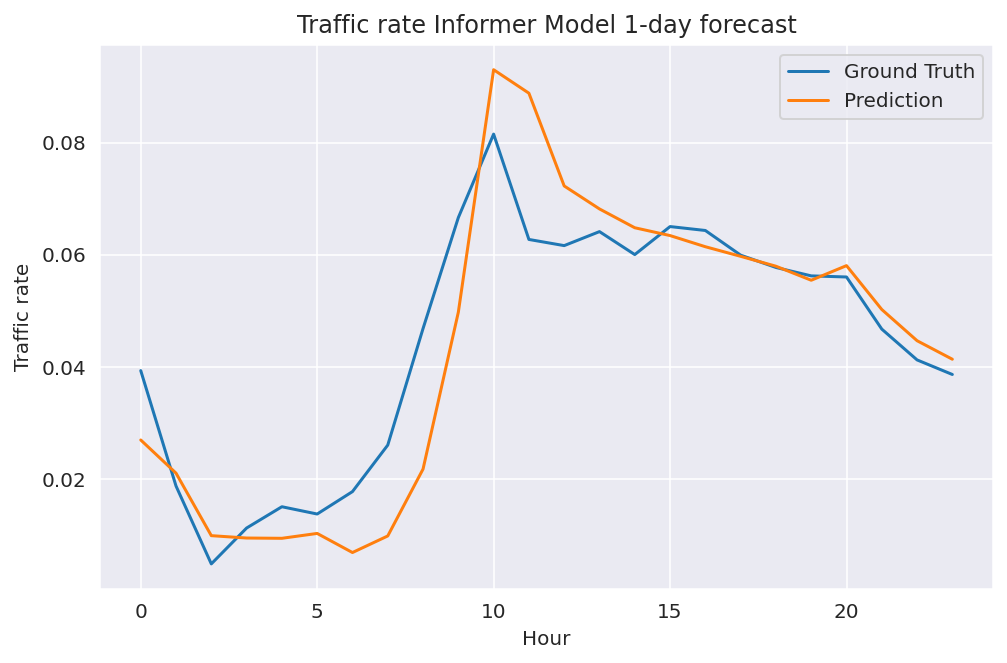

In [10]:
# Plotting a prediction sample week:
plt.figure(figsize=(8,5))
plt.plot(unscaled_trues[0,:,1], label='Ground Truth')
plt.plot(unscaled_preds[0,:,1], label='Prediction')
plt.title("Traffic rate Informer Model 1-day forecast");
plt.xlabel("Hour"), plt.ylabel("Traffic rate");
plt.legend()
plt.show()

#### Model and Forecasts Interpretation

Let's finally reload the trained model and prepare for producing outputs showing the network attention layers:

In [85]:
args.output_attention = True

exp = Exp_Informer(args)

model = exp.model
setting = "informer_custom_ftMS_sl168_ll48_pl24_dm512_nh4_el4_dl2_df2048_atprob_fc5_ebtimeF_dtTrue_exp_traffic1day"
path = os.path.join(args.checkpoints,setting,'checkpoint.pth')
model.load_state_dict(torch.load(path))

Use GPU: cuda:0


<All keys matched successfully>

In [86]:
idx = 0
for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(data_loader):
    if i!=idx:
        continue
    batch_x = batch_x.float().to(exp.device)
    batch_y = batch_y.float()

    batch_x_mark = batch_x_mark.float().to(exp.device)
    batch_y_mark = batch_y_mark.float().to(exp.device)
    
    dec_inp = torch.zeros_like(batch_y[:,-args.pred_len:,:]).float()
    dec_inp = torch.cat([batch_y[:,:args.label_len,:], dec_inp], dim=1).float().to(exp.device)
    
    outputs,attn = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)

In [87]:
attn[0].shape, attn[1].shape #, attn[2].shape

(torch.Size([1, 4, 168, 168]), torch.Size([1, 4, 85, 85]))

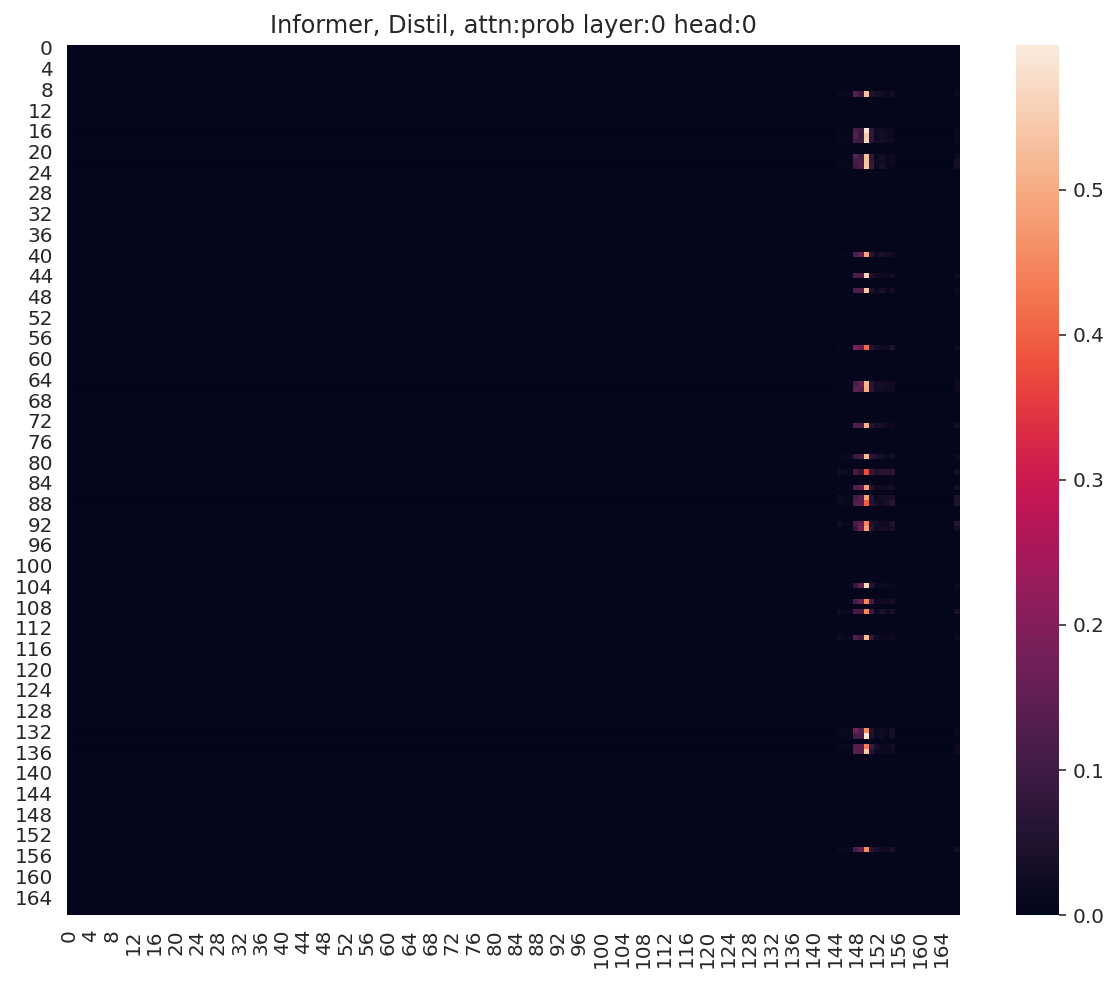

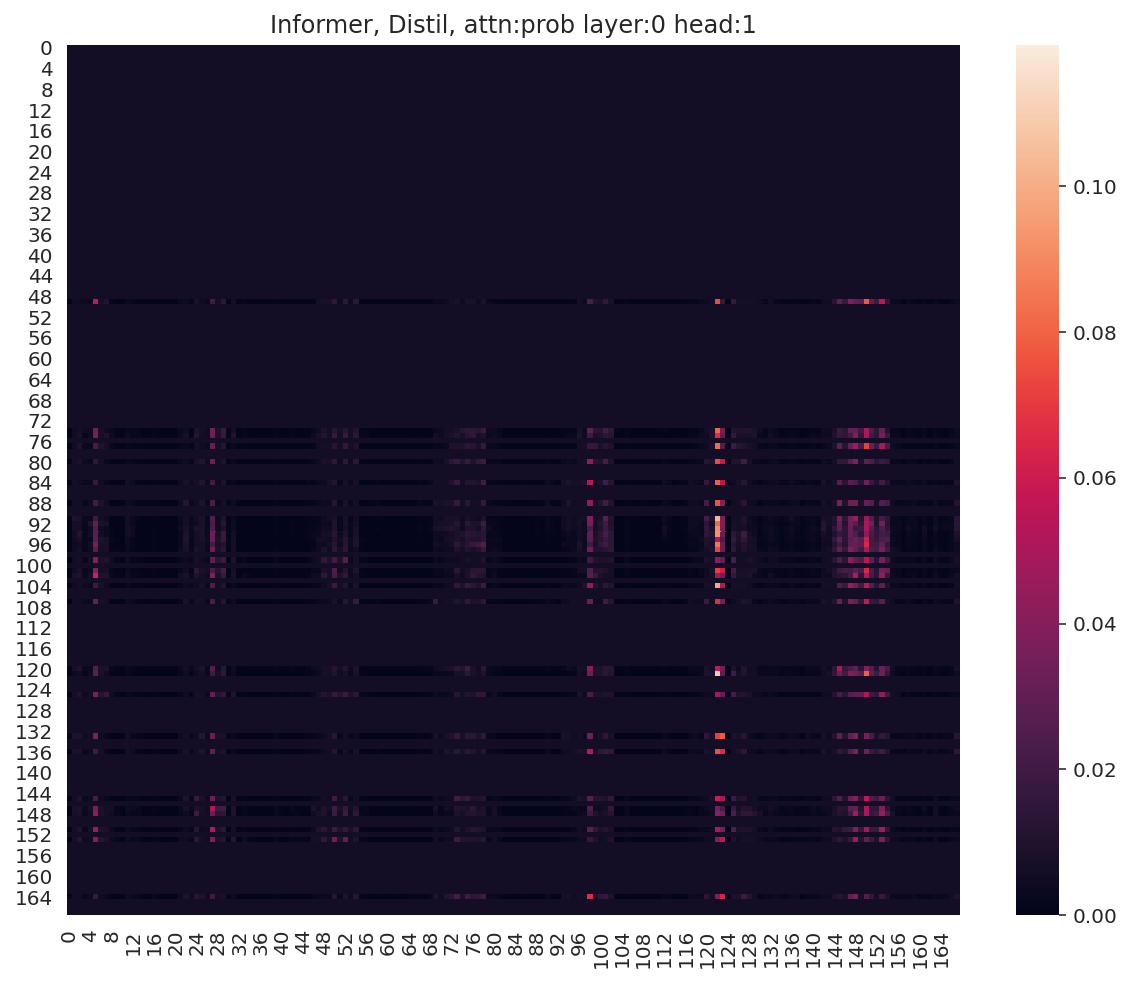

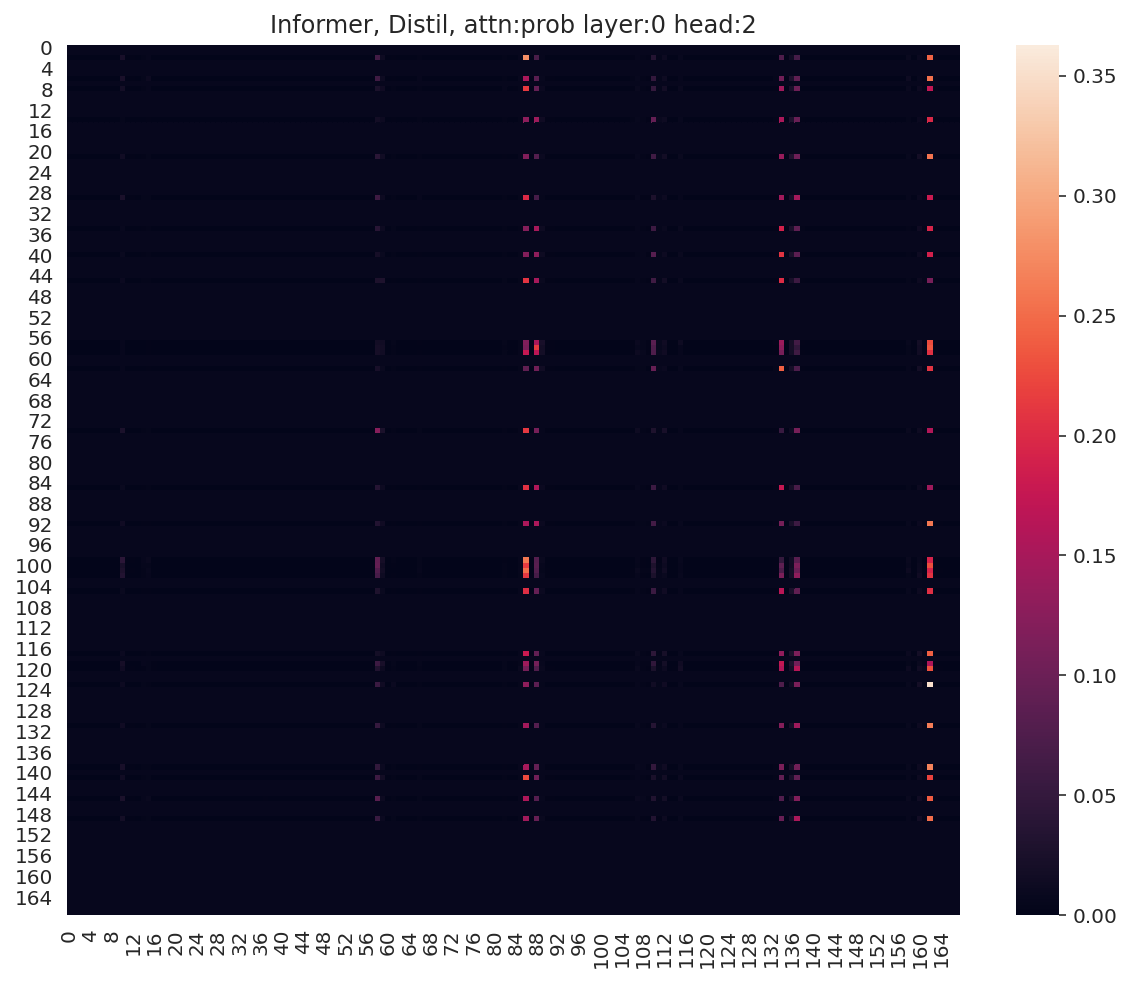

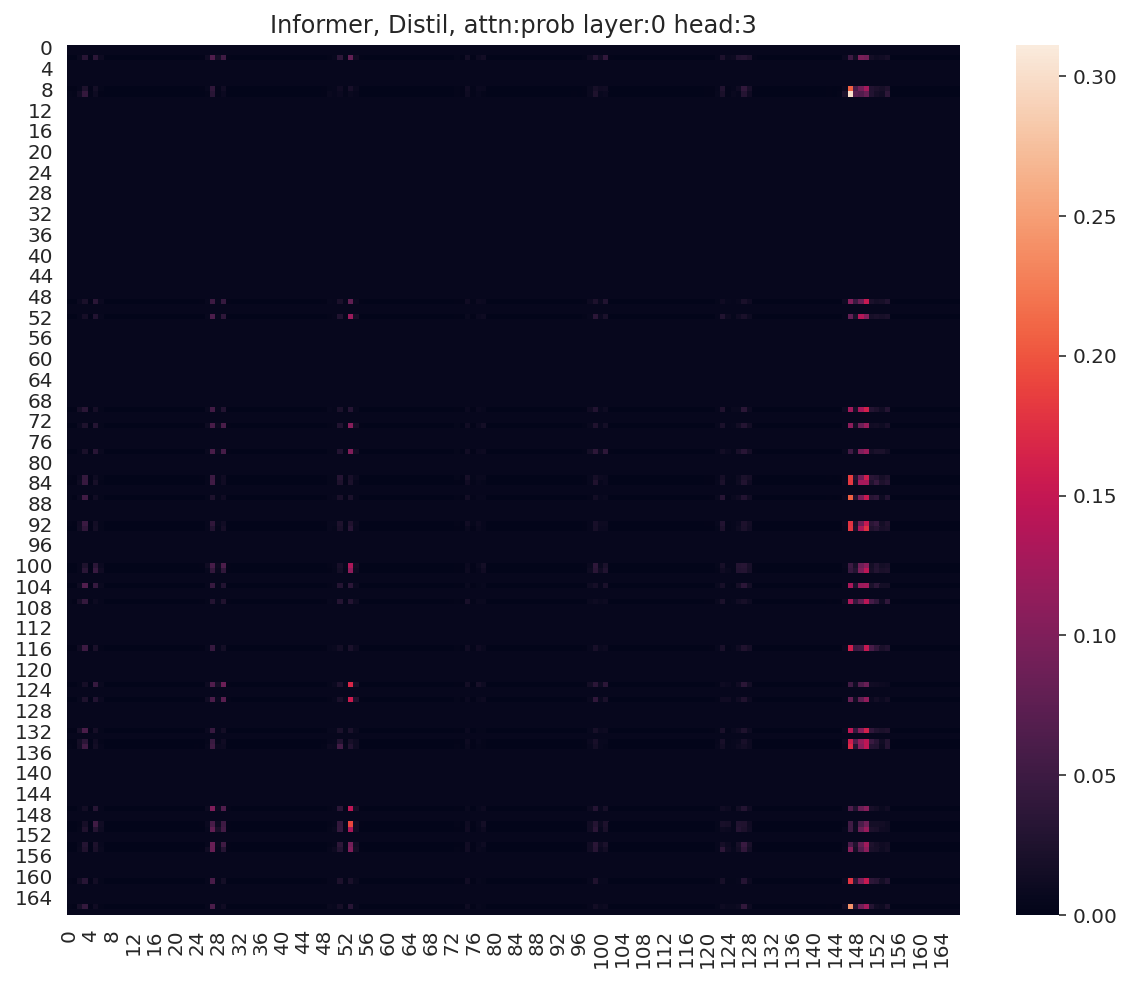

In [88]:
layer = 0
distil = 'Distil' if args.distil else 'NoDistil'
for h in range(0, args.n_heads):
    plt.figure(figsize=[10,8])
    plt.title('Informer, {}, attn:{} layer:{} head:{}'.format(distil, args.attn, layer, h))
    A = attn[layer][0,h].detach().cpu().numpy()
    ax = sns.heatmap(A, vmin=0, vmax=A.max()+0.01)
    plt.show()

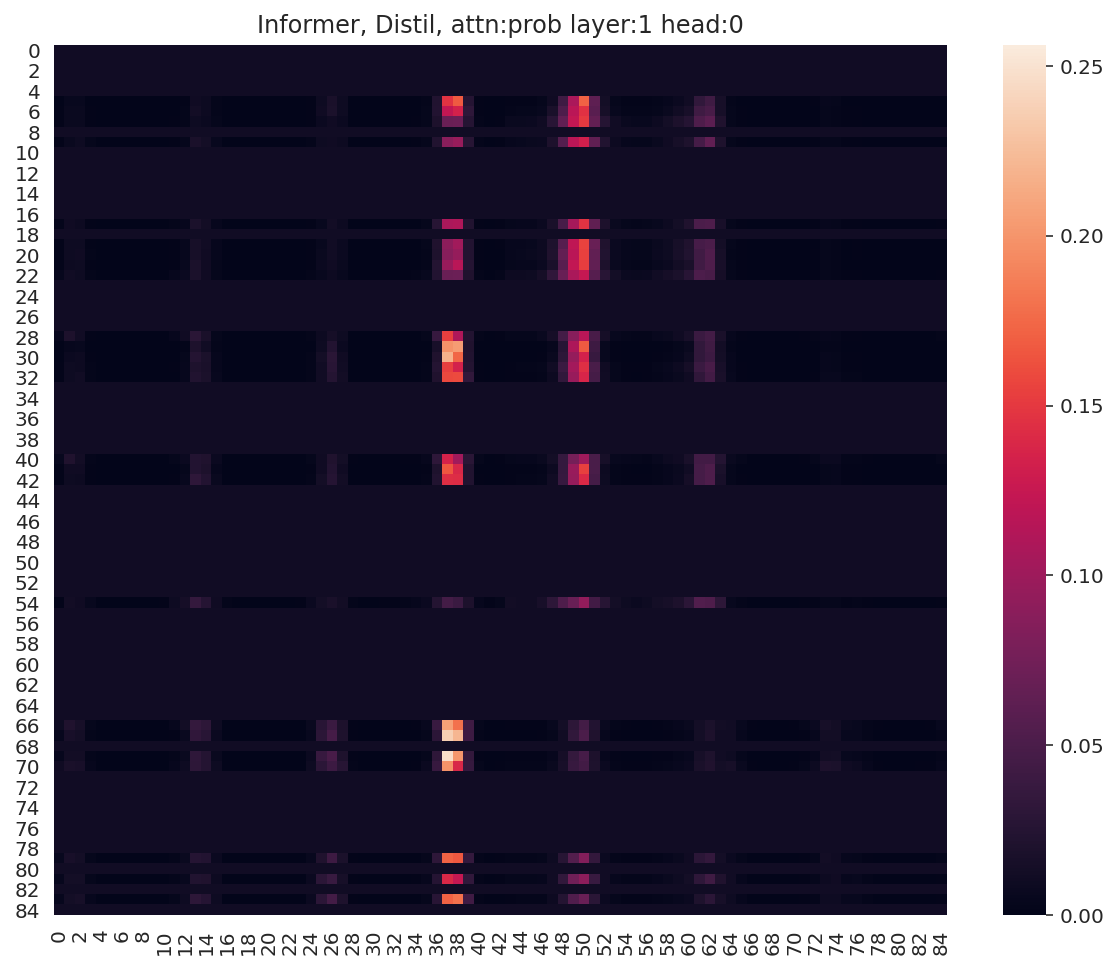

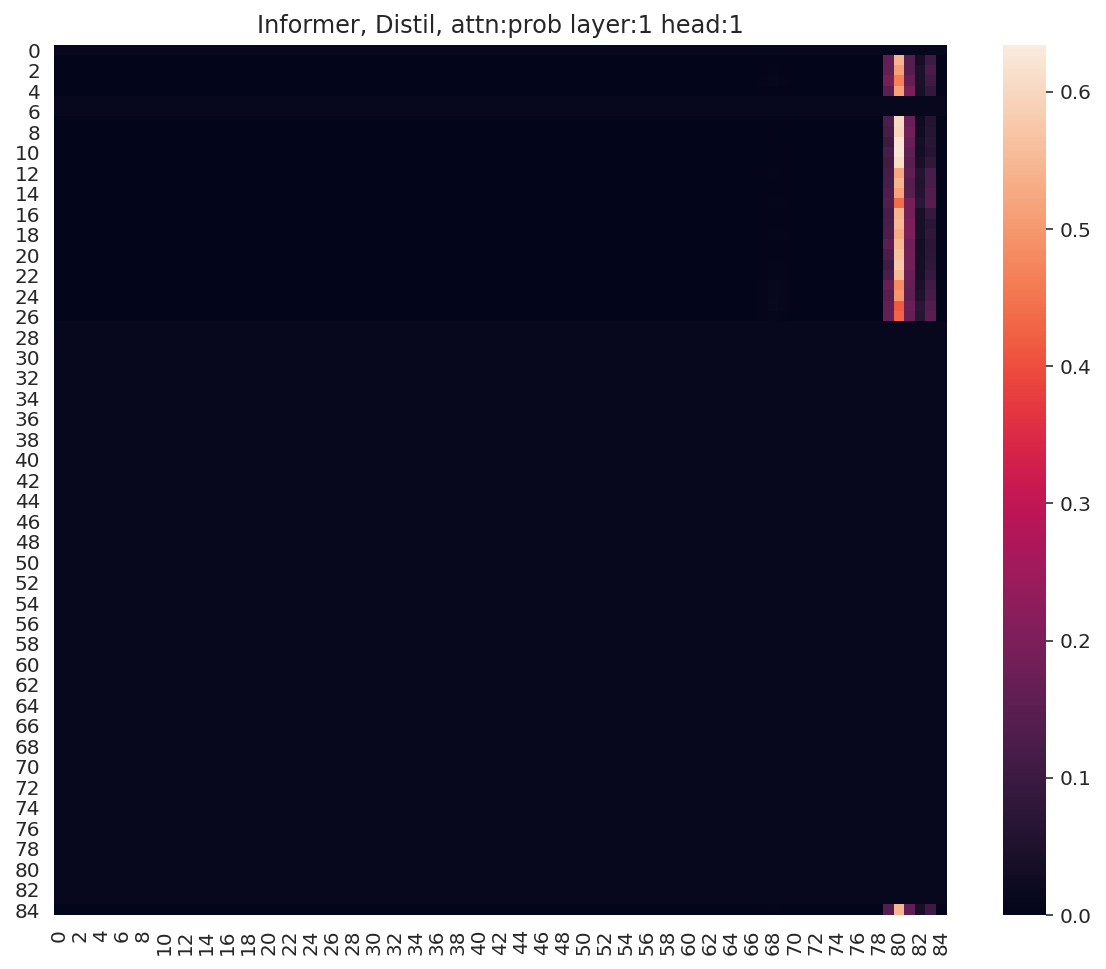

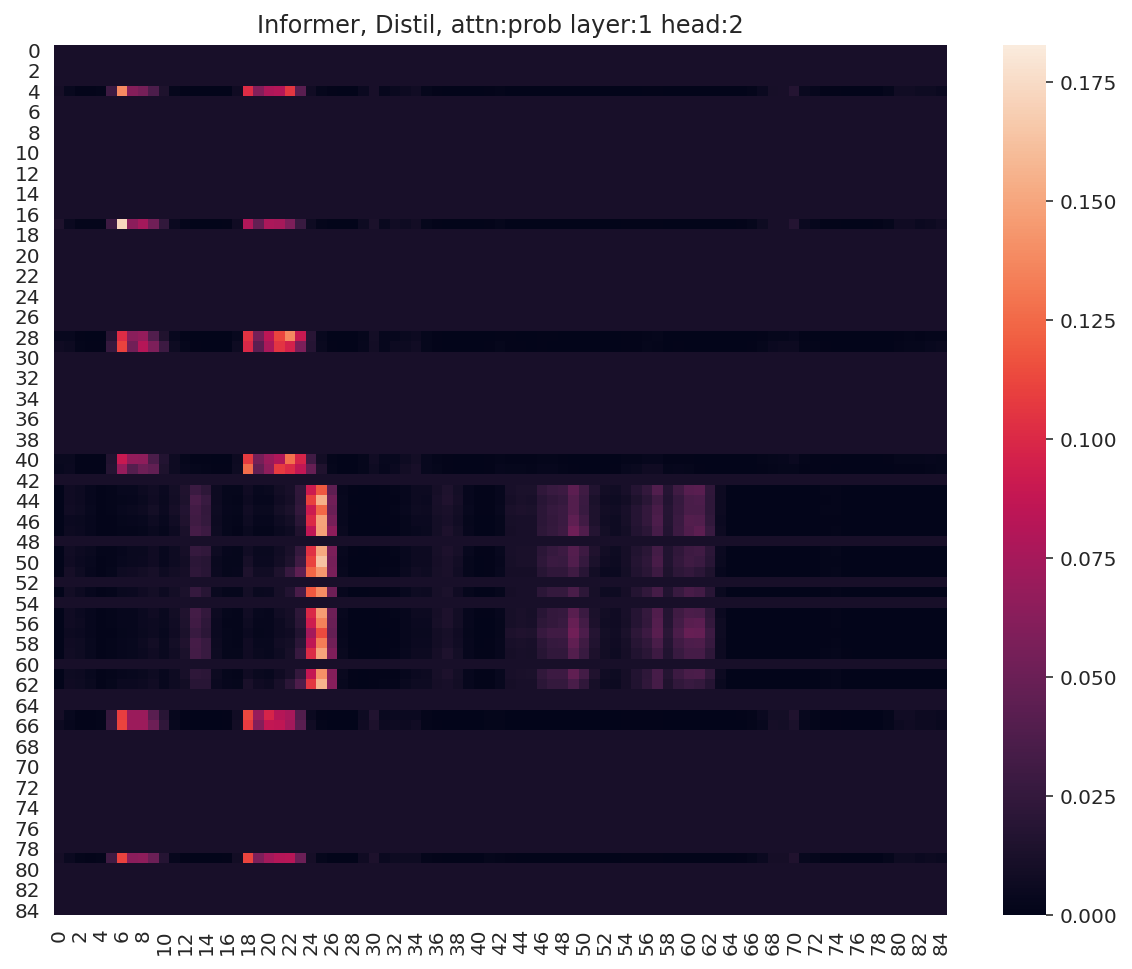

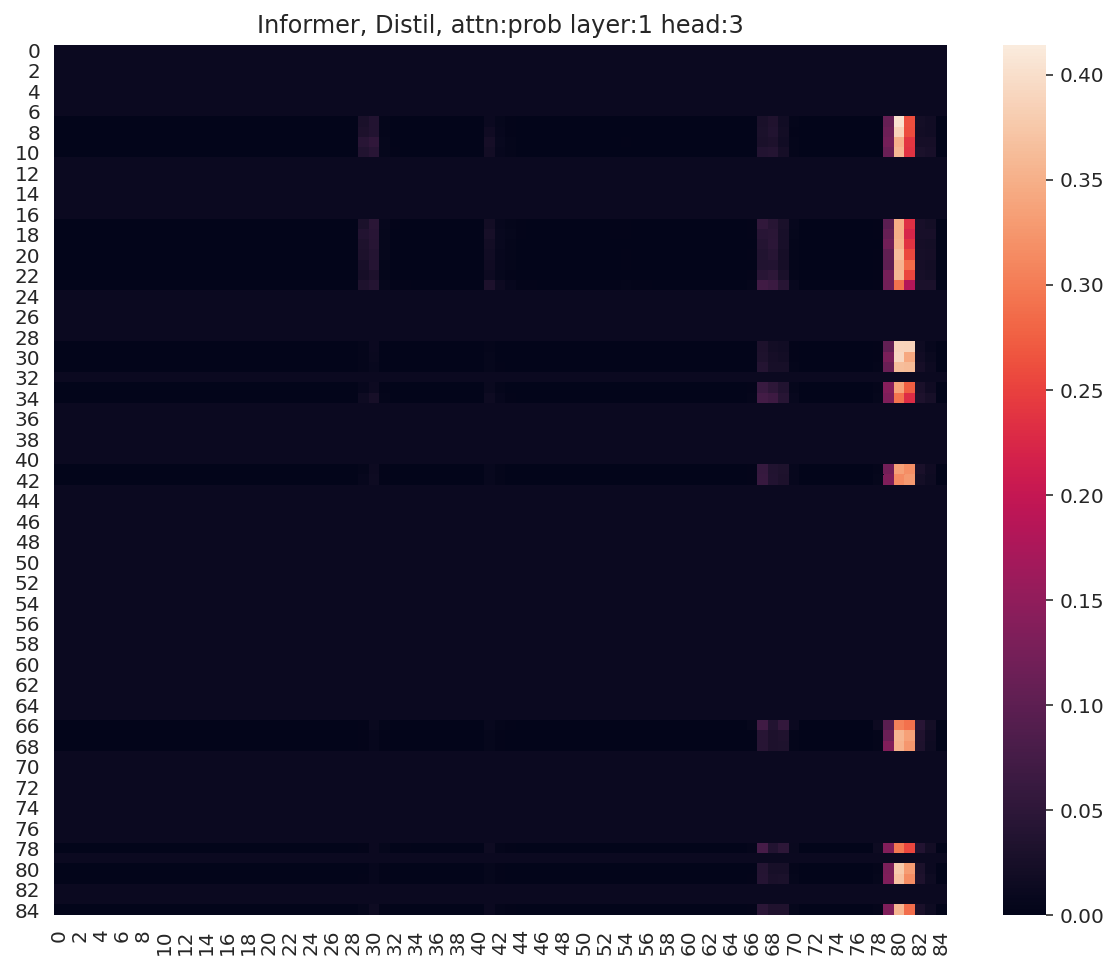

In [89]:
layer = 1
distil = 'Distil' if args.distil else 'NoDistil'
for h in range(0, args.n_heads):
    plt.figure(figsize=[10,8])
    plt.title('Informer, {}, attn:{} layer:{} head:{}'.format(distil, args.attn, layer, h))
    A = attn[layer][0,h].detach().cpu().numpy()
    ax = sns.heatmap(A, vmin=0, vmax=A.max()+0.01)
    plt.show()

### 1-week Traffic Occupation Rate Forecast Scenario

#### Informer Model Declaration (1-week horizon)

In [11]:
args = dotdict()
args.data='custom'
args.root_path = "data/aggr_data/"
args.data_path = "traffic_univ_proc_data.csv"
#Note: data is automatically scaled

timeenc = 0 if args.embed!='timeF' else 1

args.model = 'informer' 
args.target = '0'
args.freq = 'h' # hourly data (frequency)
args.features = 'MS' 
args.checkpoints = tfm_path+'Informer2020/informer_checkpoints'


args.seq_len = 24*7 # input sequence length of Informer encoder
args.label_len = 48 # start token length of Informer decoder
args.pred_len = 7*24 # prediction sequence length ===> NOW IS 1 WEEK (7 DAYS)

args.enc_in = 2 # encoder input size (2: date and target)
args.dec_in = 2 # decoder input size
args.c_out = 1 # output size
args.factor = 5 # probsparse attn factor
args.d_model = 512 # dimension of model
args.n_heads = 4 # num of heads
args.e_layers = 4 # num of encoder layers
args.d_layers = 2 # num of decoder layers
args.d_ff = 2048 # dimension of fcn in model
args.dropout = 0.1 # dropout
args.attn = 'prob' # attention used in encoder, options:[prob, full]
args.embed = 'timeF' # time features encoding, options:[timeF, fixed, learned]
args.activation = 'gelu' # activation
args.distil = True # whether to use distilling in encoder
args.output_attention = False # whether to output attention in ecoder

args.batch_size = 32 
args.learning_rate = 0.0001
args.loss = 'mse'
args.lradj = 'type1'
args.use_amp = False # whether to use automatic mixed precision training

args.num_workers = 0
args.itr = 1
args.train_epochs = 8
args.patience = 2
args.des = 'exp'

args.use_gpu = True if torch.cuda.is_available() else False
args.gpu = 0
args.use_multi_gpu = False

#### Model Training and Evaluation

In [12]:
setting = '{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_at{}_fc{}_eb{}_dt{}_{}_{}'\
          .format(args.model, args.data, args.features, args.seq_len, args.label_len, args.pred_len, 
                  args.d_model, args.n_heads, args.e_layers, args.d_layers, args.d_ff, 
                  args.attn, args.factor, args.embed, args.distil, args.des, "traffic1week")

exp = Exp_Informer(args)

Use GPU: cuda:0


In [102]:
print('>>>>>>>start training : {}>>>>>>>>>>>>>>>>>>>>>>>>>>'.format(setting))
exp.train(setting)

print('>>>>>>>testing : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
exp.test(setting)

torch.cuda.empty_cache()

>>>>>>>start training : informer_custom_ftMS_sl168_ll48_pl168_dm512_nh4_el4_dl2_df2048_atprob_fc5_ebtimeF_dtTrue_exp_traffic1week>>>>>>>>>>>>>>>>>>>>>>>>>>
train 11945
val 1589
test 3341
	iters: 100, epoch: 1 | loss: 1.0302711
	speed: 0.2813s/iter; left time: 811.5183s
	iters: 200, epoch: 1 | loss: 0.9734372
	speed: 0.2912s/iter; left time: 811.0174s
	iters: 300, epoch: 1 | loss: 0.8158048
	speed: 0.2847s/iter; left time: 764.4585s
Epoch: 1 cost time: 106.6277506351471
Epoch: 1, Steps: 373 | Train Loss: 0.9214966 Vali Loss: 0.2863147 Test Loss: 1.1034331
Validation loss decreased (inf --> 0.286315).  Saving model ...
Updating learning rate to 0.0001
	iters: 100, epoch: 2 | loss: 0.5814172
	speed: 0.6691s/iter; left time: 1680.7895s
	iters: 200, epoch: 2 | loss: 0.4405489
	speed: 0.2847s/iter; left time: 686.5810s
	iters: 300, epoch: 2 | loss: 0.4358881
	speed: 0.2846s/iter; left time: 657.9339s
Epoch: 2 cost time: 106.42815470695496
Epoch: 2, Steps: 373 | Train Loss: 0.4542763 Vali Los

In [103]:
# storing trained model parameters
torch.save(exp.model.state_dict(), "../trained_models/informer_model_traffic_1week.pth" )

In [13]:
timeenc = 0 if args.embed!='timeF' else 1

shuffle_flag = False; drop_last = True; batch_size = 1

data_set = Dataset_Custom(
    root_path=args.root_path,
    data_path=args.data_path,
    flag='test',
    size=[args.seq_len, args.label_len, args.pred_len],
    features=args.features,
    timeenc=timeenc,
    target=args.target,
    freq=args.freq
)

data_loader = DataLoader(
    data_set,
    batch_size=batch_size,
    shuffle=shuffle_flag,
    num_workers=args.num_workers,
    drop_last=drop_last)

In [14]:
preds = np.load('./results/'+setting+'/pred.npy')
trues = np.load('./results/'+setting+'/true.npy')
# have shape [samples, pred_len, dimensions]

unscaled_trues = data_set.inverse_transform(trues)
unscaled_preds = data_set.inverse_transform(preds)

test_mae = []
for week_window in range(len(unscaled_trues)):
    week_trues = unscaled_trues[week_window,:,1]
    week_preds = unscaled_preds[week_window,:,1]
    week_MAE = mean_absolute_error(week_trues, week_preds)
    test_mae.append(week_MAE)

print("Average test MAE:", sum(test_mae)/len(test_mae))

Average test MAE: 0.020054724681852168


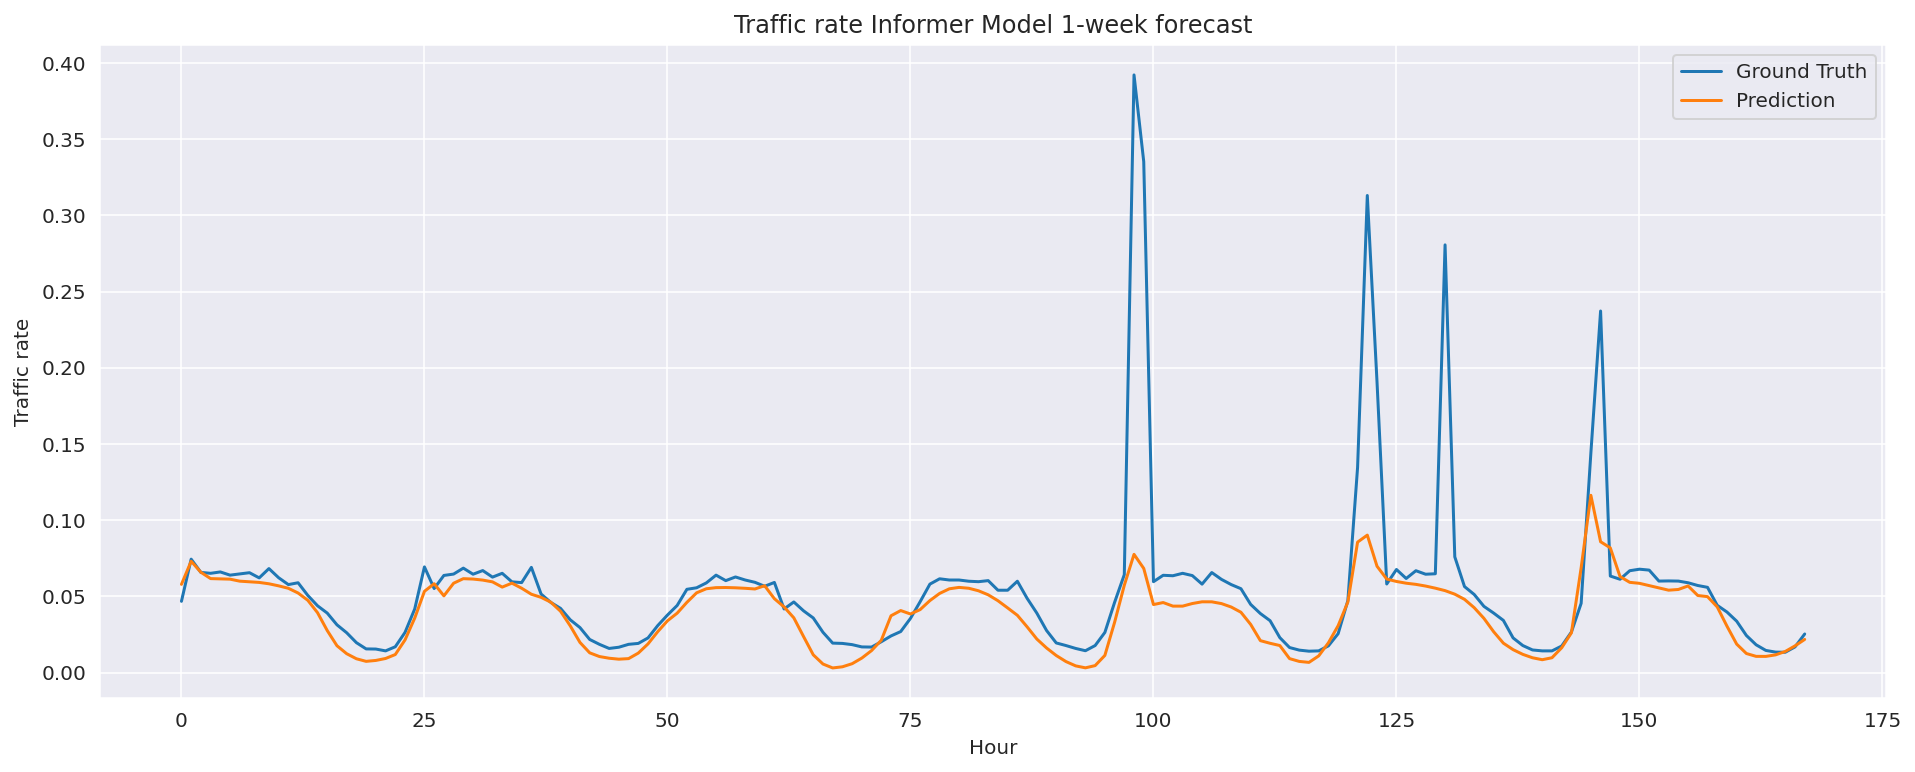

In [15]:
# Plotting a prediction sample week:
plt.figure()
plt.plot(unscaled_trues[80,:,1], label='Ground Truth')
plt.plot(unscaled_preds[80,:,1], label='Prediction')
plt.title("Traffic rate Informer Model 1-week forecast");
plt.xlabel("Hour"), plt.ylabel("Traffic rate");
plt.legend()
plt.show()

#### Model and Forecasts Interpretation

In [107]:
args.output_attention = True

exp = Exp_Informer(args)

model = exp.model
setting = "informer_custom_ftMS_sl168_ll48_pl168_dm512_nh4_el4_dl2_df2048_atprob_fc5_ebtimeF_dtTrue_exp_traffic1week"
path = os.path.join(args.checkpoints,setting,'checkpoint.pth')
model.load_state_dict(torch.load(path))

Use GPU: cuda:0


<All keys matched successfully>

In [108]:
# attention visualization
idx = 0
for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(data_loader):
    if i!=idx:
        continue
    batch_x = batch_x.float().to(exp.device)
    batch_y = batch_y.float()

    batch_x_mark = batch_x_mark.float().to(exp.device)
    batch_y_mark = batch_y_mark.float().to(exp.device)
    
    dec_inp = torch.zeros_like(batch_y[:,-args.pred_len:,:]).float()
    dec_inp = torch.cat([batch_y[:,:args.label_len,:], dec_inp], dim=1).float().to(exp.device)
    
    outputs,attn = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)

In [109]:
attn[0].shape, attn[1].shape #, attn[2].shape

(torch.Size([1, 4, 168, 168]), torch.Size([1, 4, 85, 85]))

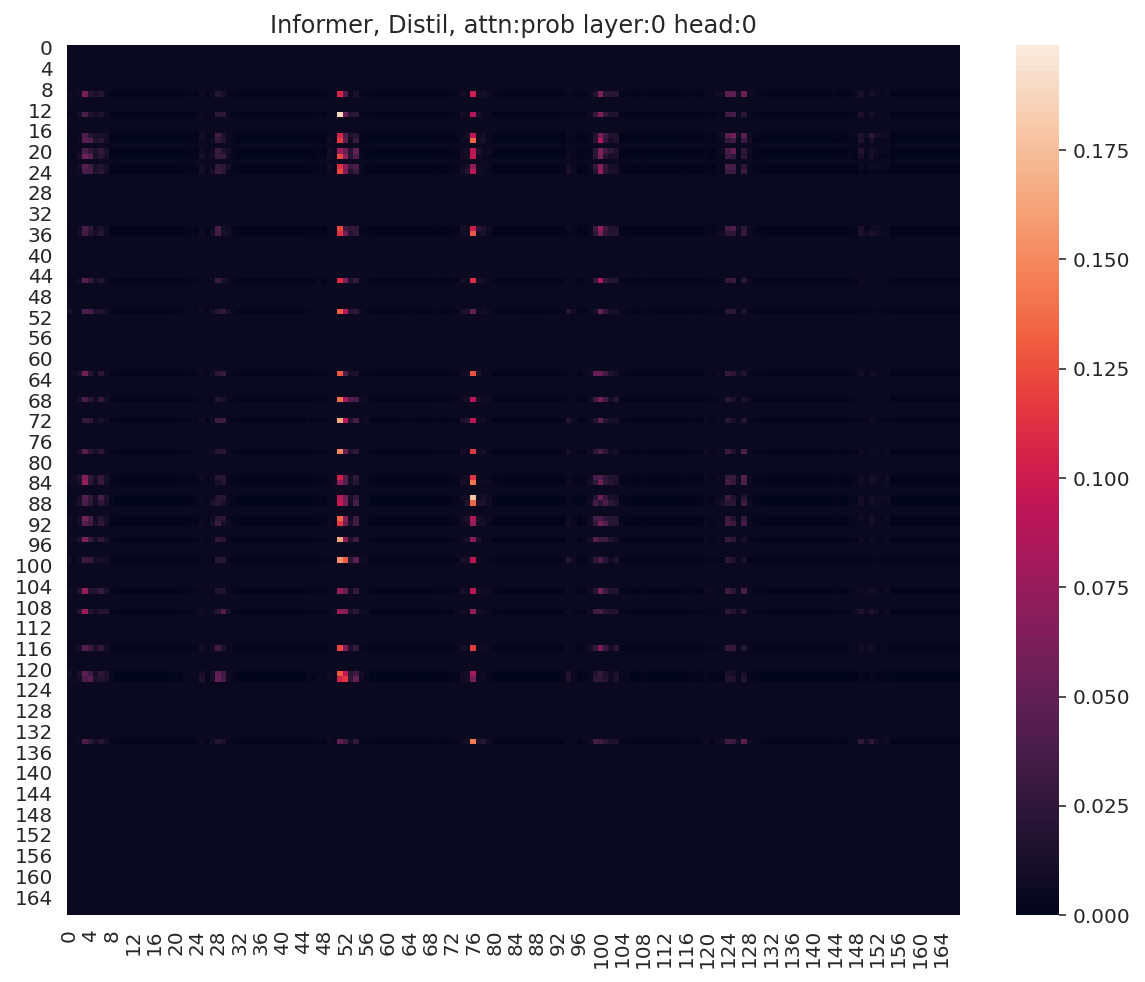

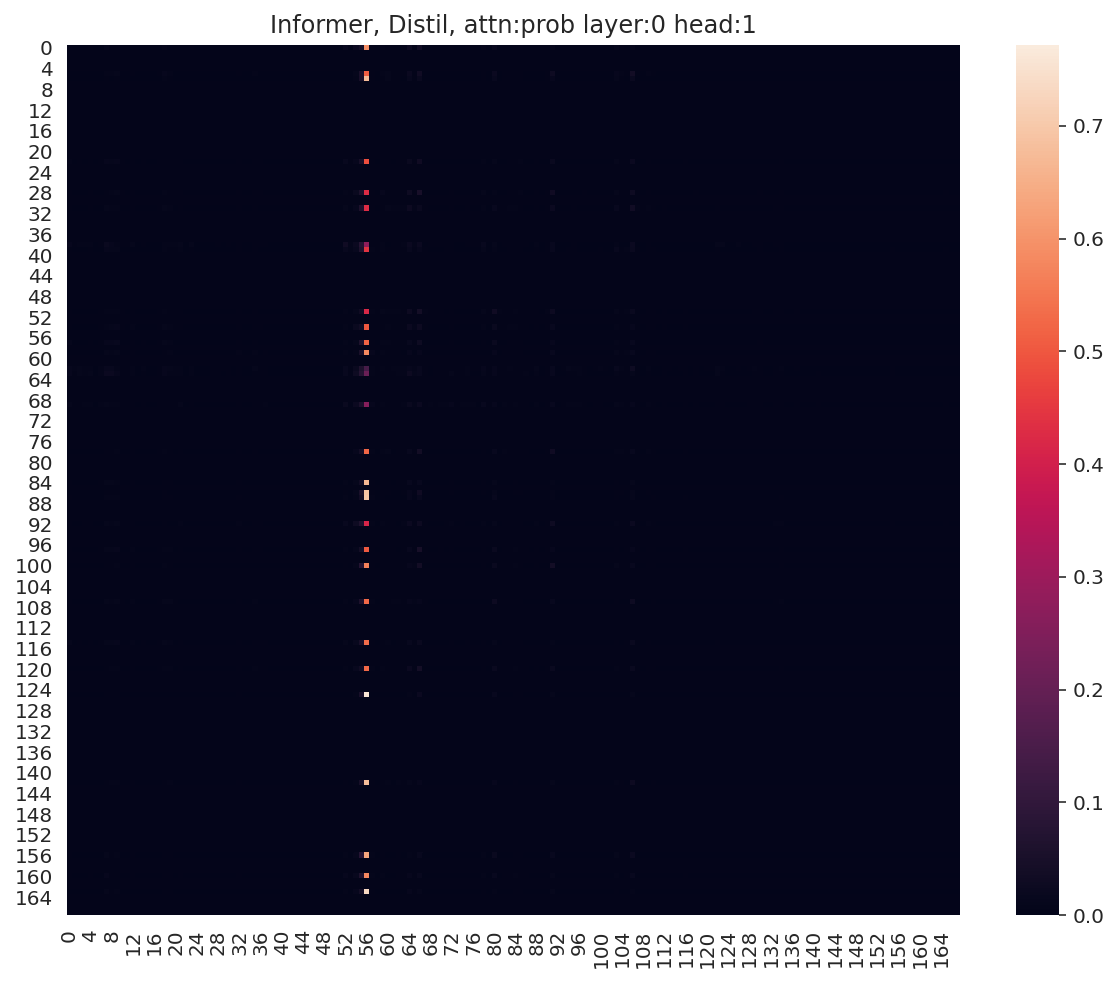

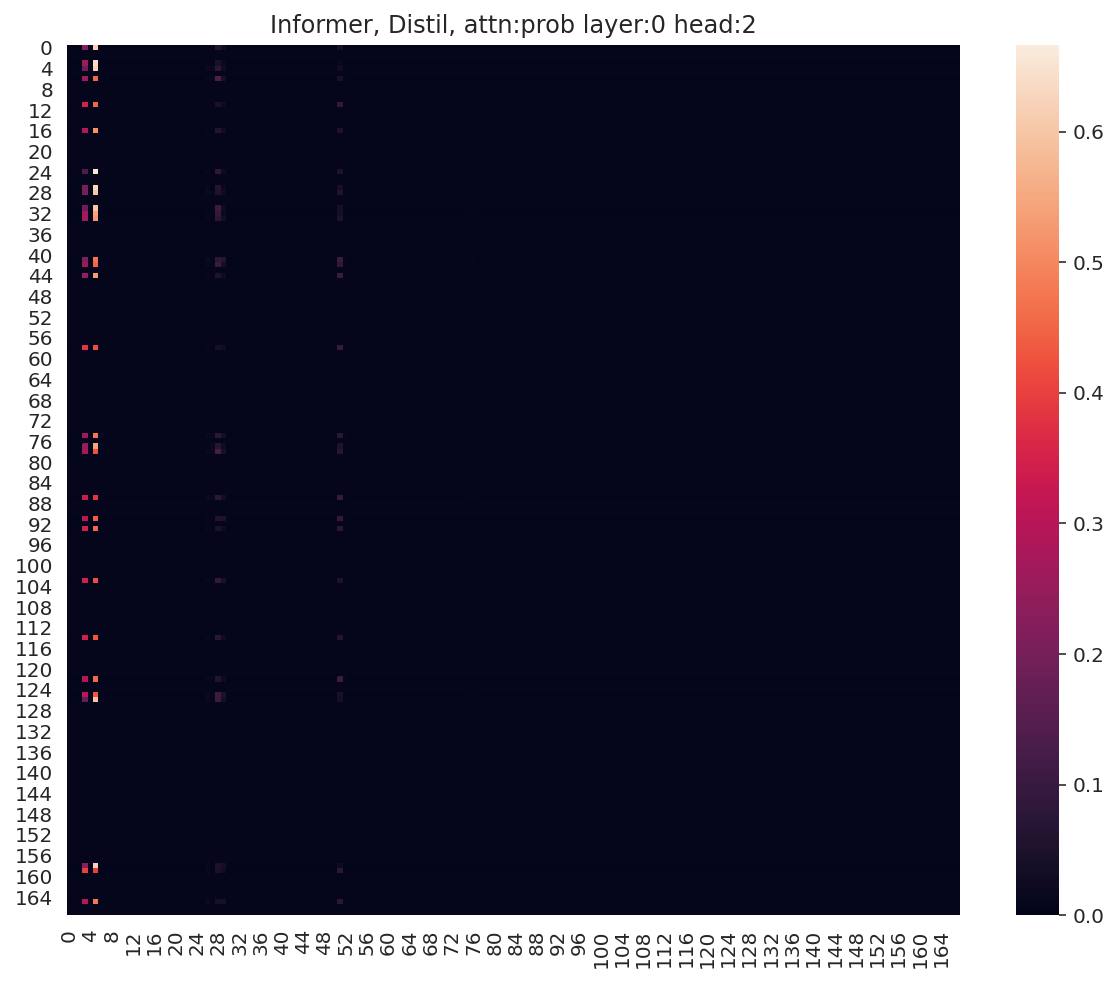

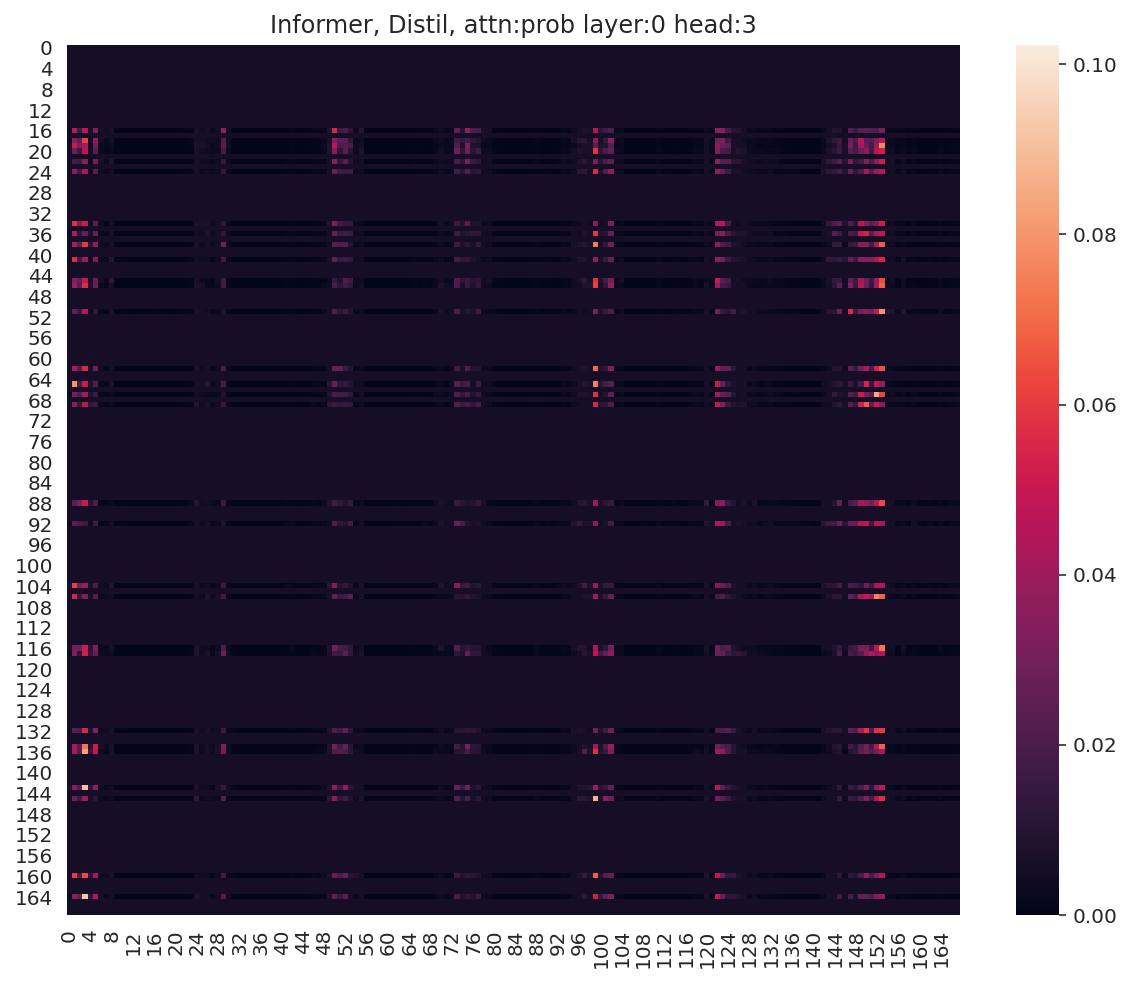

In [110]:
layer = 0
distil = 'Distil' if args.distil else 'NoDistil'
for h in range(0, args.n_heads):
    plt.figure(figsize=[10,8])
    plt.title('Informer, {}, attn:{} layer:{} head:{}'.format(distil, args.attn, layer, h))
    A = attn[layer][0,h].detach().cpu().numpy()
    ax = sns.heatmap(A, vmin=0, vmax=A.max()+0.01)
    plt.show()

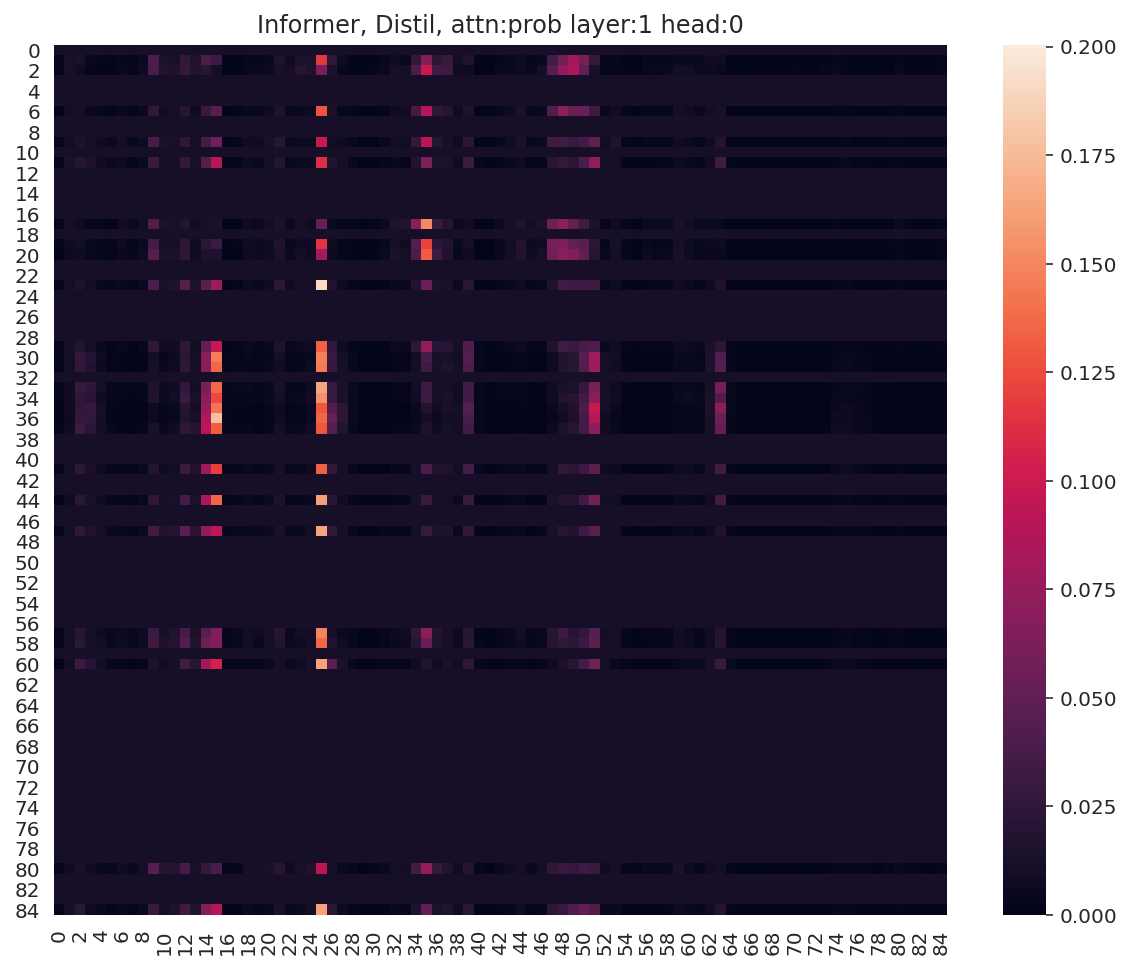

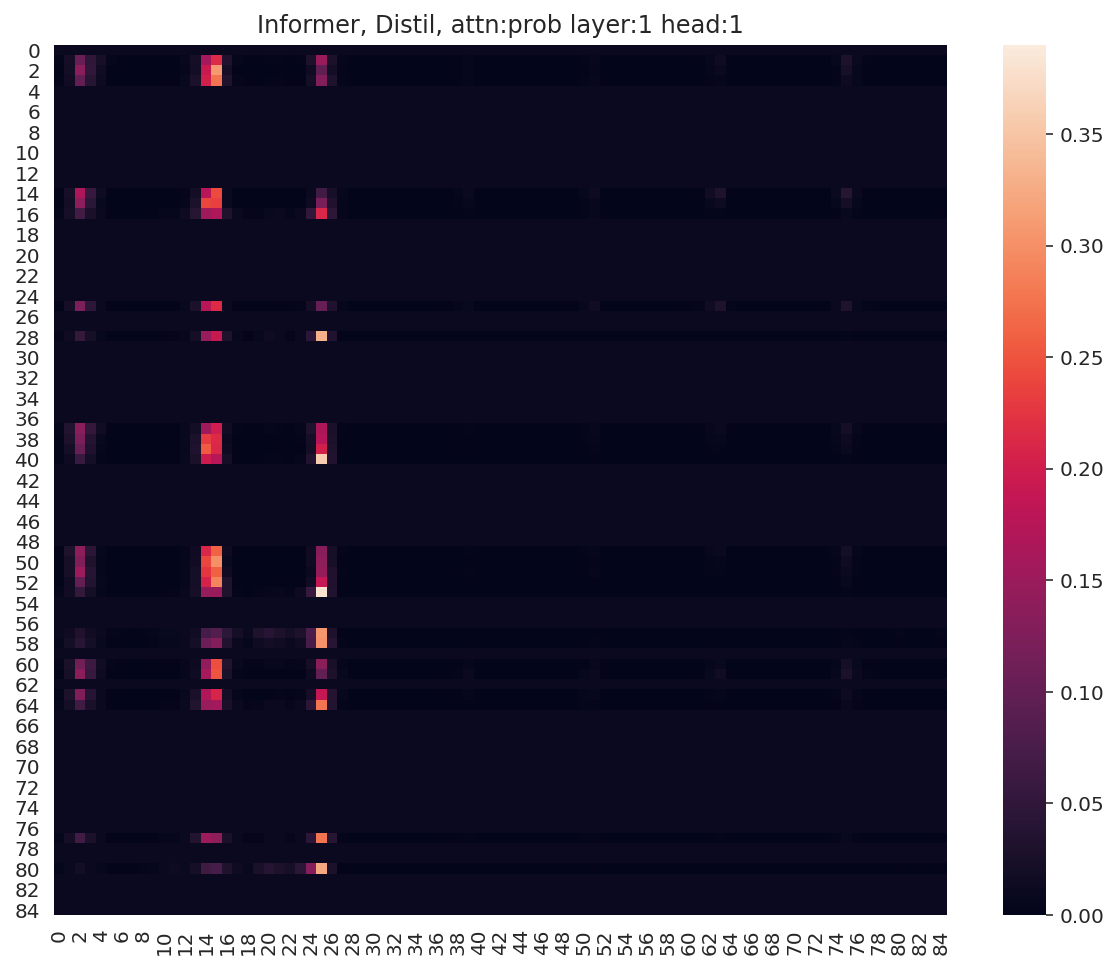

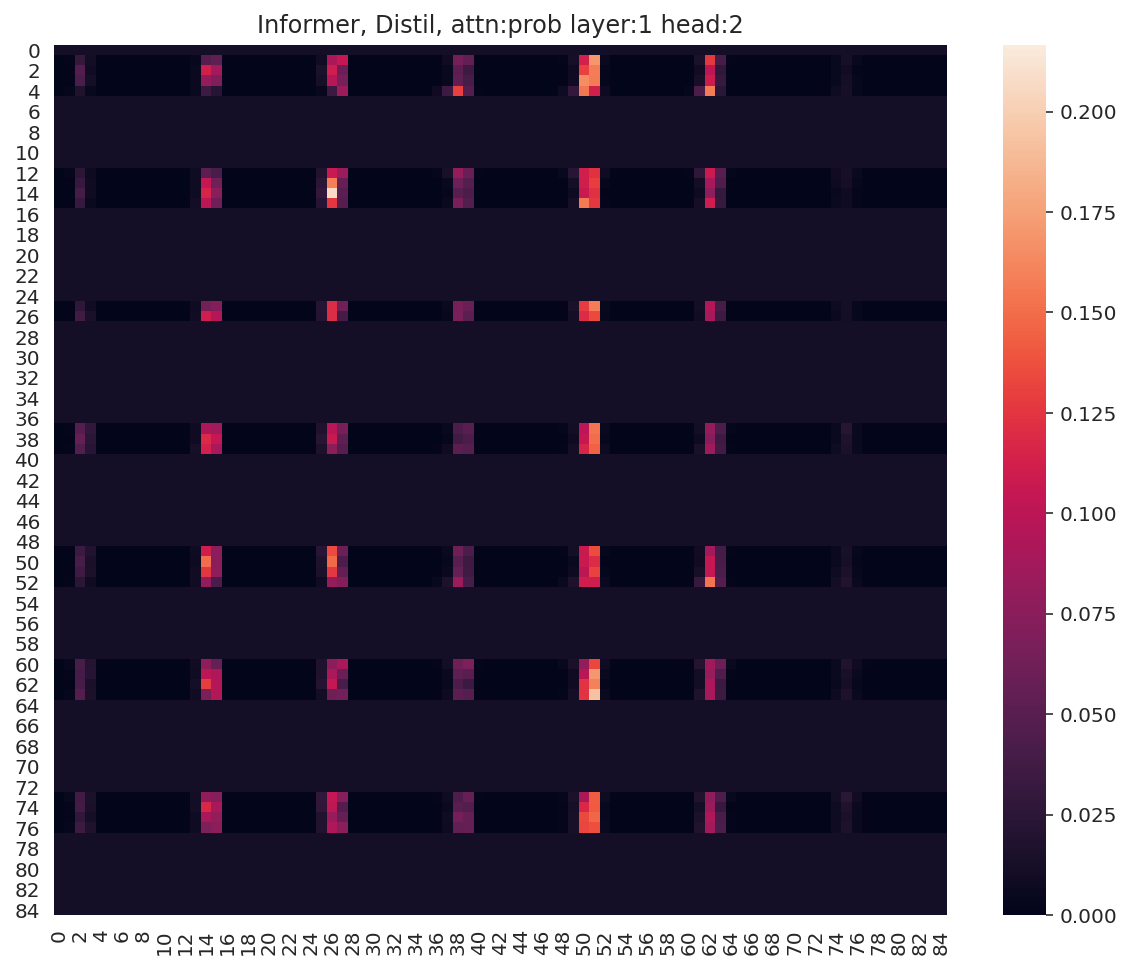

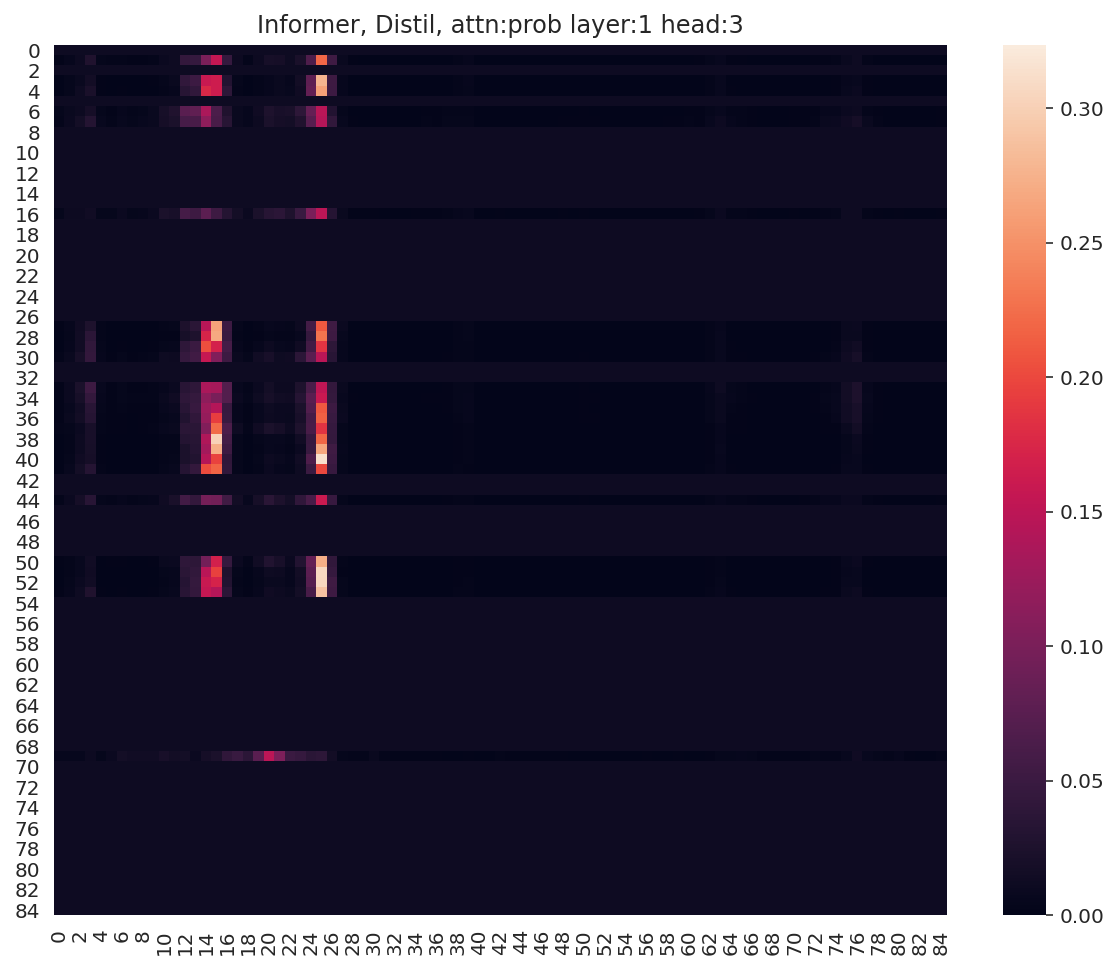

In [111]:
layer = 1
distil = 'Distil' if args.distil else 'NoDistil'
for h in range(0, args.n_heads):
    plt.figure(figsize=[10,8])
    plt.title('Informer, {}, attn:{} layer:{} head:{}'.format(distil, args.attn, layer, h))
    A = attn[layer][0,h].detach().cpu().numpy()
    ax = sns.heatmap(A, vmin=0, vmax=A.max()+0.01)
    plt.show()